# ATAC preprocessing using Signac

This notebook covers the preprocessing (data loading, QC and diminsionality reduction) of the sc-ATAC modality for the Multiome data sets.

It contains R code only, so an **R kernel** needs to be chosen.

On Saturn cloud, make sure to use the **neurips-2** image and add `/srv/conda/envs/saturn/bin/R -e "IRkernel::installspec()"` in the startup skript (advanced options).

Files needed:

- Count matrix (output of the load and subset notebook: templates/Load_aggr_h5ad_data.ipynb)
    - e.g.: s1d1_subset.h5ad
    
- 10x metadata (per_barcode_metrics.csv, adjust site and donor to your sample)
    - Download from S3 bucket here:
        - s3://openproblems-bio/neurips2021/site1/production/donor01.lot3054455/atac/cellranger_out/per_barcode_metrics.csv
        
- Fragment files (atac_fragments.tsv.gz & atac_fragments.tsv.gz.tbi, adjust site and donor to your sample)
    - Download from S3 bucket here:
        - s3://openproblems-bio/neurips2021/site1/production/donor01.lot3054455/atac/cellranger_out/atac_fragments.tsv.gz
        - s3://openproblems-bio/neurips2021/site1/production/donor01.lot3054455/atac/cellranger_out/atac_fragments.tsv.gz.tbi
        
- Reference genome gtf file (genes.gtf.gz, same for all samples)
    - Download from S3 bucket here:
        - s3://openproblems-bio/neurips2021/refdata-cellranger-arc-GRCh38-2020-A-2.0.0/genes/genes.gtf.gz
   


## Load libraries

In [1]:
# Ensure correct libpaths order - should only be relevant for local installations
.libPaths() # Check if libPath of environment is listed first

[1] "/opt/conda/envs/saturn/lib/R/library"

In [2]:
# If not, change with:
# .libPaths(.libPaths()[c(2,1)])

In [3]:
suppressMessages(library(Signac))
suppressMessages(library(Seurat))
suppressMessages(library(GenomeInfoDb))
library(ggplot2)
library(patchwork)
library(anndata)
library(stringr)

Set seed for reproducibility

In [4]:
set.seed(42)

Set working directory to sample dictionary

In [5]:
getwd()

[1] "/home/jovyan/project/neurips2021-notebooks/notebooks/analysis/s2d4"

In [6]:
setwd('/home/jovyan/project/neurips2021-notebooks/')

## Load Data

In [7]:
# Set paths

h5ad_path = "./data/multiome/raw_data/s2d4/s2d4_subset.h5ad"  # changed from h5 to h5ad file
meta_path = "./data/multiome/raw_data/s2d4/per_barcode_metrics.csv"
frag_path = "./data/multiome/raw_data/s2d4/atac_fragments.tsv.gz"
gref_path = "./data/multiome/genes.gtf.gz"

In [8]:
adata <- anndata::read_h5ad(h5ad_path)

In [9]:
counts <- adata$X

In [10]:
counts <- t(counts)

In [11]:
metadata <- read.csv(
  file = meta_path,
  header = TRUE,
  row.names = 1
)

In [12]:
head(metadata)

gex_barcode        atac_barcode       is_cell
AAACAGCCAAACAACA-1 AAACAGCCAAACAACA-1 ACAGCGGGTGTGTTAC-1 0      
AAACAGCCAAACATAG-1 AAACAGCCAAACATAG-1 ACAGCGGGTTGTTCTT-1 0      
AAACAGCCAAACCCTA-1 AAACAGCCAAACCCTA-1 ACAGCGGGTAACAGGC-1 0      
AAACAGCCAAACCTAT-1 AAACAGCCAAACCTAT-1 ACAGCGGGTGCGCGAA-1 0      
AAACAGCCAAACCTTG-1 AAACAGCCAAACCTTG-1 ACAGCGGGTCCTCCAT-1 0      
AAACAGCCAAACGCGA-1 AAACAGCCAAACGCGA-1 ACAGCGGGTCATGGTT-1 0      
                   excluded_reason gex_raw_reads gex_mapped_reads
AAACAGCCAAACAACA-1 0                18            18             
AAACAGCCAAACATAG-1 0                18            16             
AAACAGCCAAACCCTA-1 0               924           871             
AAACAGCCAAACCTAT-1 0                10            10             
AAACAGCCAAACCTTG-1 0                13            10             
AAACAGCCAAACGCGA-1 0                 6             6             
                   gex_conf_intergenic_reads gex_conf_exonic_reads
AAACAGCCAAACAACA-1  0                         16                  
AAACAGCCAAACATAG-1  0                          5                  
AAACAGCCAAACCCTA-1 40                        457                  
AAACAGCCAAACCTAT-1  0                          6                  
AAACAGCCAAACCTTG-1  0                          7                  
AAACAGCCAAACGCGA-1  0                          6                  
                   gex_conf_intronic_reads gex_conf_exonic_unique_reads ⋯
AAACAGCCAAACAACA-1   2                      16                          ⋯
AAACAGCCAAACATAG-1  11                       5                          ⋯
AAACAGCCAAACCCTA-1 169                     452                          ⋯
AAACAGCCAAACCTAT-1   3                       6                          ⋯
AAACAGCCAAACCTTG-1   3                       7                          ⋯
AAACAGCCAAACGCGA-1   0                       1                          ⋯
                   atac_raw_reads atac_unmapped_reads atac_lowmapq
AAACAGCCAAACAACA-1  0             0                   0           
AAACAGCCAAACATAG-1  3             0                   1           
AAACAGCCAAACCCTA-1 85             5                   6           
AAACAGCCAAACCTAT-1  1             0                   1           
AAACAGCCAAACCTTG-1 12             0                   0           
AAACAGCCAAACGCGA-1  3             0                   0           
                   atac_dup_reads atac_chimeric_reads atac_mitochondrial_reads
AAACAGCCAAACAACA-1  0             0                    0                      
AAACAGCCAAACATAG-1  0             0                    0                      
AAACAGCCAAACCCTA-1 21             0                   13                      
AAACAGCCAAACCTAT-1  0             0                    0                      
AAACAGCCAAACCTTG-1  2             0                    1                      
AAACAGCCAAACGCGA-1  2             0                    0                      
                   atac_fragments atac_TSS_fragments atac_peak_region_fragments
AAACAGCCAAACAACA-1  0             0                   0                        
AAACAGCCAAACATAG-1  2             1                   1                        
AAACAGCCAAACCCTA-1 40             8                  18                        
AAACAGCCAAACCTAT-1  0             0                   0                        
AAACAGCCAAACCTTG-1  9             2                   5                        
AAACAGCCAAACGCGA-1  1             1                   1                        
                   atac_peak_region_cutsites
AAACAGCCAAACAACA-1  0                       
AAACAGCCAAACATAG-1  2                       
AAACAGCCAAACCCTA-1 35                       
AAACAGCCAAACCTAT-1  0                       
AAACAGCCAAACCTTG-1 10                       
AAACAGCCAAACGCGA-1  2

In [13]:
barcodes = str_split(row.names(metadata),"-",simplify=T)[,1]
barcodes_mat = str_split(colnames(counts),"-",simplify=T)[,1]

barcodes_mat = paste(barcodes_mat ,"-1",sep="")

#row.names(metadata) <- barcodes
colnames(counts) <- barcodes_mat

Later we only add the atac metrics to the Signac object^^

### Add Genome Annotation

In [14]:
gtf <- rtracklayer::import(gref_path)

In [15]:
gene.coords <- gtf[gtf$type == 'gene']

In [16]:
gene.coords <- gene.coords[! is.na(gene.coords$gene_name),]

In [17]:
# Signac needs gene_biotype as a column identifier
gene.coords$gene_biotype <- gene.coords$gene_type

In [18]:
gene.coords <- keepStandardChromosomes(gene.coords, pruning.mode = 'coarse')
genome(gene.coords) <- 'GRCh38'

### Set up Signac Assay

This step also includes a feature selection step, whereby only peaks with fragments detected in at least 15 cells are included

In [19]:
chrom_assay <- CreateChromatinAssay(
    counts = counts,
    sep = c(":", "-"),
    genome = 'GRCh38',
    fragments = frag_path,
    annotation = gene.coords,
    min.cells = 15
)

Computing hash



Binarize counts

In [20]:
peaks_bin <- BinarizeCounts(chrom_assay)

Add meta data

In [21]:
meta_cols <- c(grep( "atac" , colnames(metadata),value=TRUE))

In [22]:
atac_metadata = metadata[,meta_cols]

In [23]:
bmnc <- CreateSeuratObject(
  counts = chrom_assay,
  assay = "peaks",
  meta.data = atac_metadata
)

Warning message in CreateSeuratObject.Assay(counts = chrom_assay, assay = "peaks", :
“Some cells in meta.data not present in provided counts matrix.”


In [24]:
# Check out the object
bmnc[['peaks']]

ChromatinAssay data with 158058 features for 10062 cells
Variable features: 0 
Genome: GRCh38 
Annotation present: TRUE 
Motifs present: FALSE 
Fragment files: 1 

## QC

### Metric description

We use a combination of QC metrics derived from the 10x metadata and newly calculated metrics:
- **atac_fragments:** Total number of fragments per cell; cellular sequencing depth (includes all fragment before binarization of the matrix)
- **TSS.enrichment:** Transcriptional start site (TSS) enrichment score; ratio of fragments centered at the TSS to fragments in TSS-flanking regions
- **reads_in_peaks_frac:** Fraction of fragments in peak regions; fraction of all fragments that fall within ATAC-seq peaks
- **blacklist_fraction:** Ratio of reads in genomic blacklist regions; blacklist regions are often associated with artefactual signal (defined by ENCODE)
- **nucleosome_signal:** Nucleosome banding pattern; length of paired-end reads should follow pattern that corresponds to DNA length needed to be wrapped around one or multiple nucleosomes

## Calculate QC metrics

In [25]:
# compute TSS enrichment score per cell (this step takes a few minutes)
bmnc <- TSSEnrichment(object = bmnc, fast = TRUE)

Extracting TSS positions

Extracting fragments at TSSs


Computing TSS enrichment score



In [26]:
# add fraction of reads in peaks
bmnc <- FRiP(
  object = bmnc,
  assay = 'peaks',
  total.fragments = 'atac_fragments',
  col.name = "reads_in_peaks_frac"
)

Calculating fraction of reads in peaks per cell



In [27]:
# get blacklist regions and calculate fraktion of peaks in those regions
bl_regions <- blacklist_hg38_unified

bmnc$blacklist_fraction <- FractionCountsInRegion(
  object = bmnc, 
  assay = 'peaks',
  regions = bl_regions
)

In [28]:
# compute nucleosome signal per cell
bmnc <- NucleosomeSignal(object = bmnc)

## Plot QC metrics

### Overview

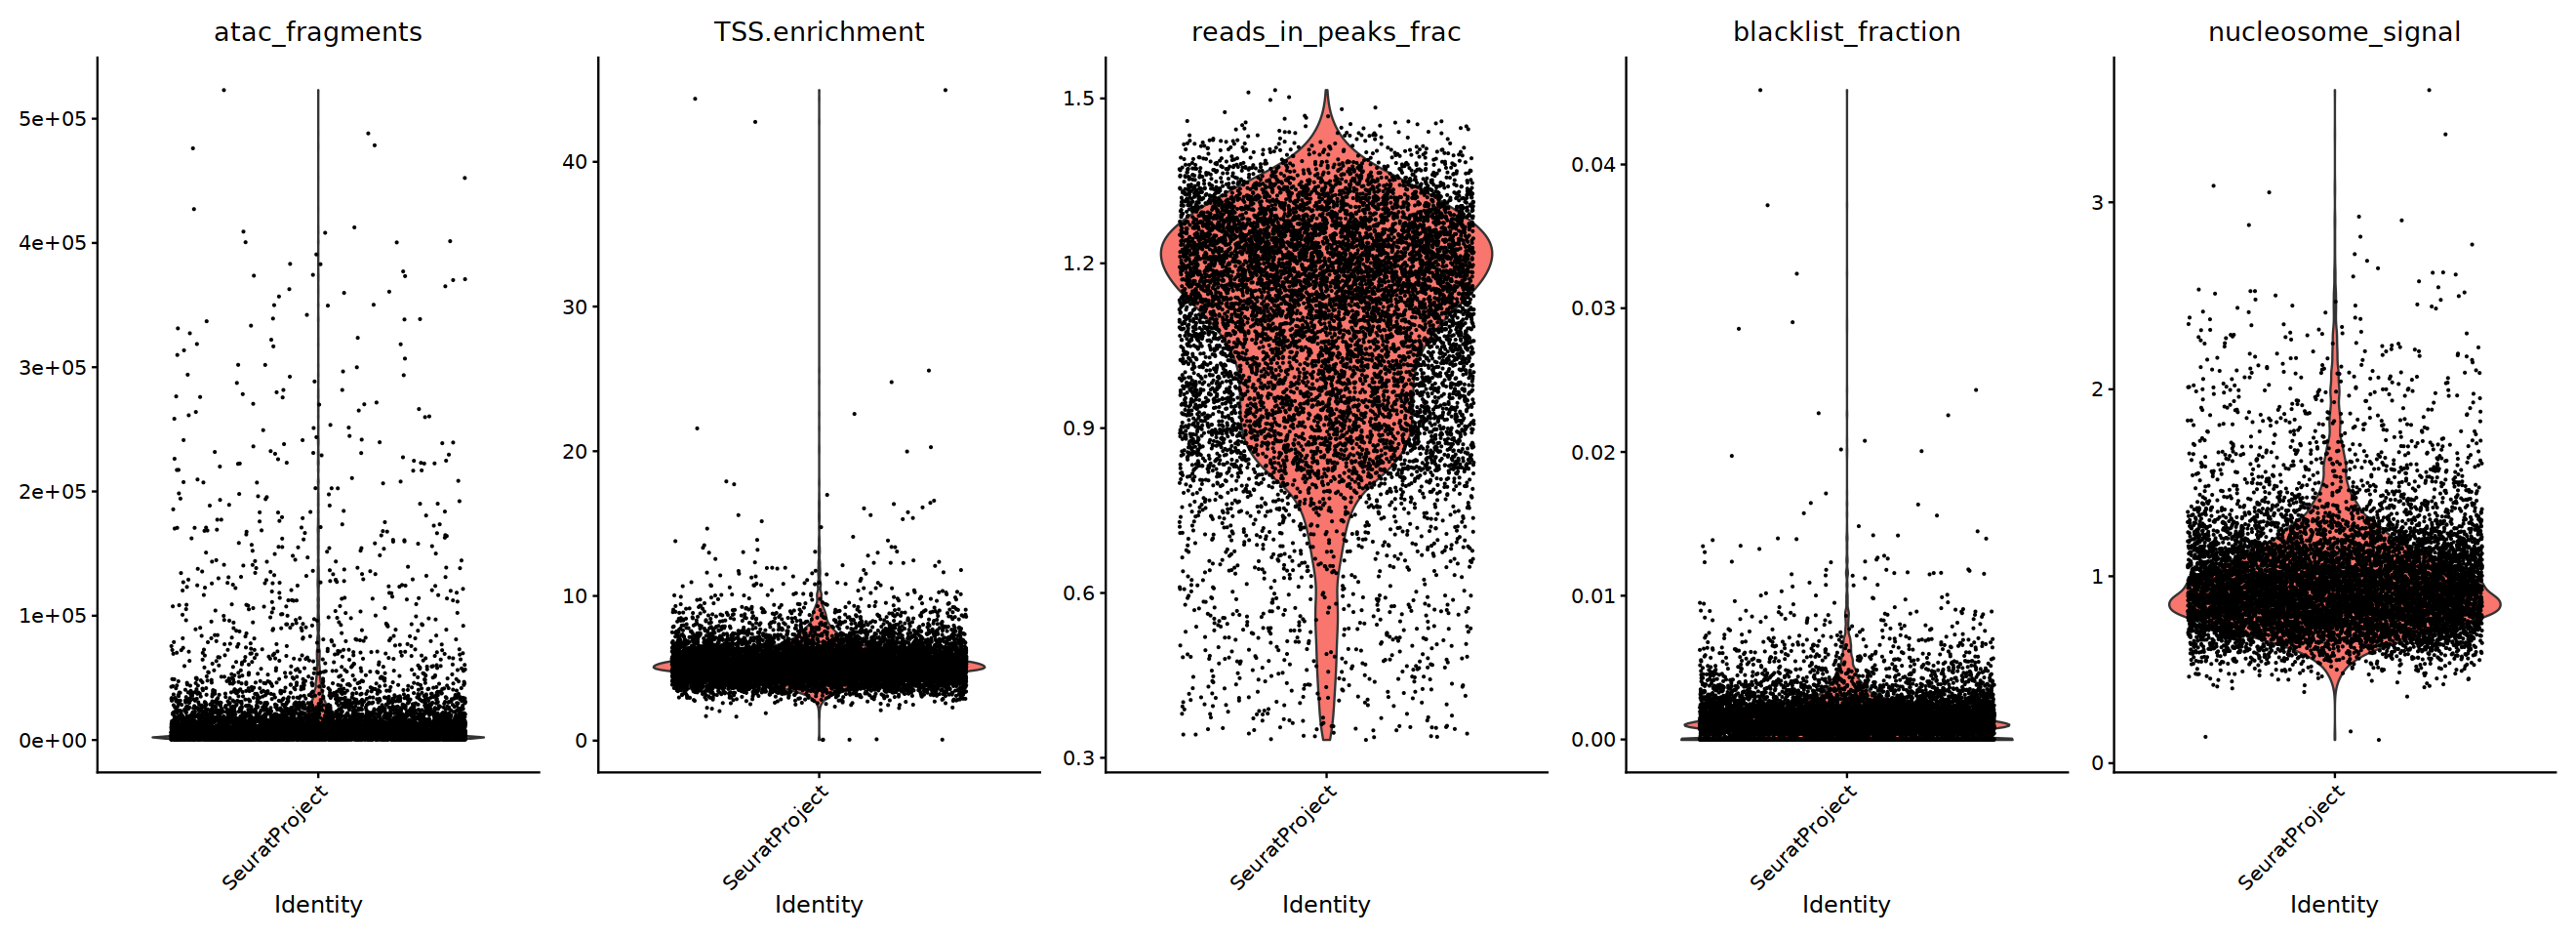

In [29]:
# overview of single metrics

options(repr.plot.width=22, repr.plot.height=8) # figure size

VlnPlot(
  object = bmnc,
  features = c('atac_fragments','TSS.enrichment', 'reads_in_peaks_frac',
               'blacklist_fraction', 'nucleosome_signal'),
  pt.size = 0.1,
  ncol = 5
)

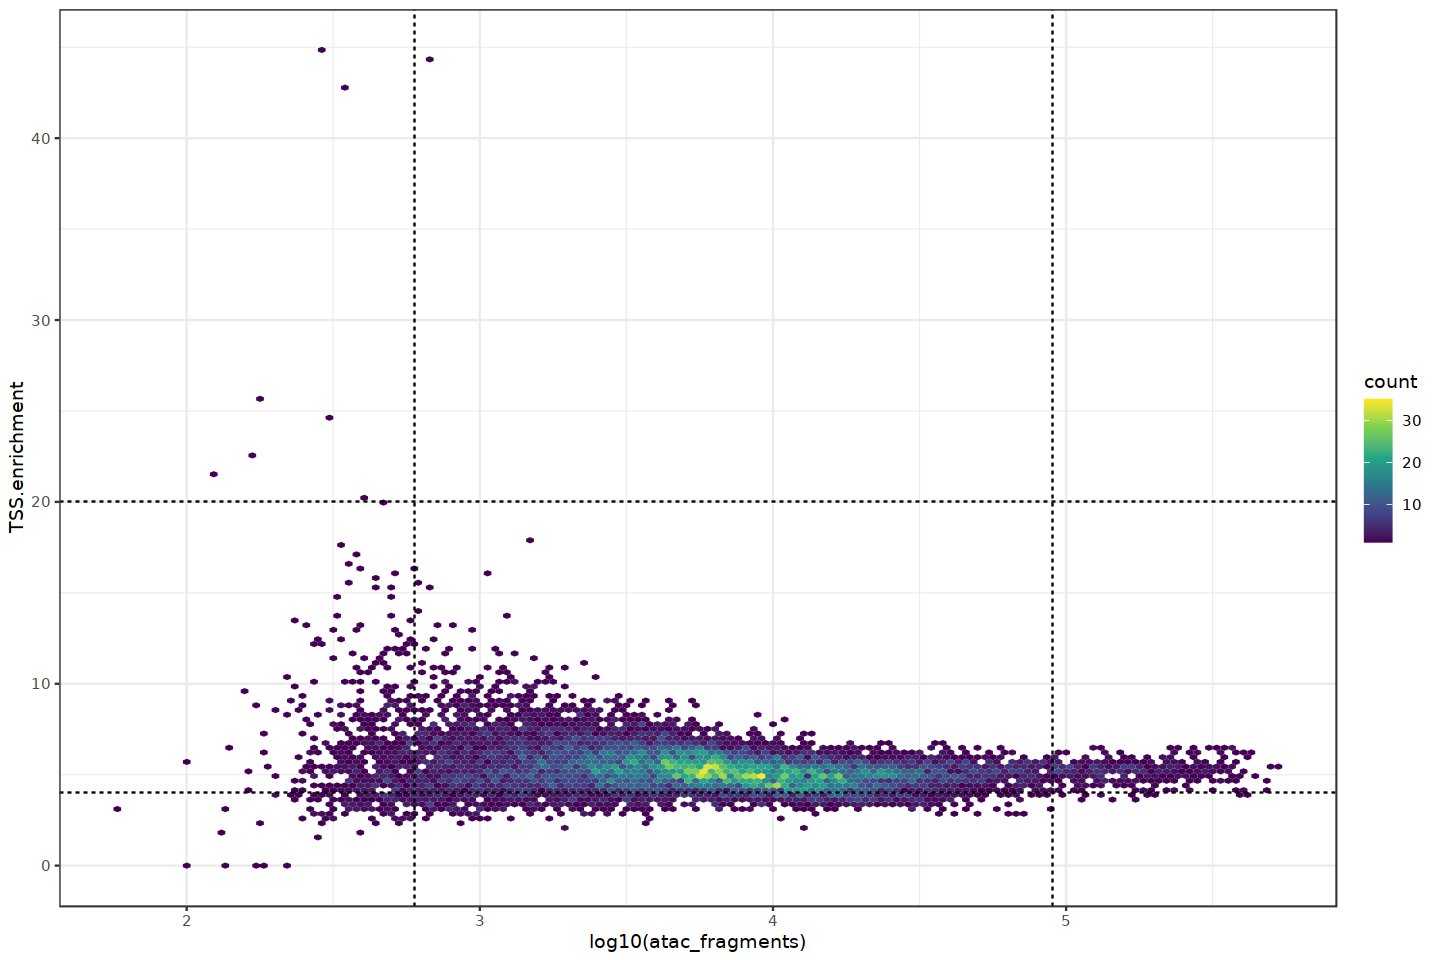

In [30]:
# log(fragments) vs TSS enrichment with potential cut-offs

options(repr.plot.width=12, repr.plot.height=8) # figure size

ggplot(bmnc@meta.data, aes(x=log10(atac_fragments), y=TSS.enrichment) ) +
  geom_hex(bins = 150) +
  scale_fill_continuous(type = "viridis") +
  theme_bw()+
  geom_hline(yintercept = 4, lty = "dashed") +
  geom_hline(yintercept = 20, lty = "dashed") +
  geom_vline(xintercept = log10(600), lty = "dashed") +
  geom_vline(xintercept = log10(90000), lty = "dashed")

### Single metrics with cut-off decisions

Next, we plot each metric as a violin plot or histogram and decide suitable cut-offs.

In general, choose rather **permissive thresholds** since we have a downstreem QC step when combining modalities.

#### Total number of fragments

In [51]:
lower_totfraq_thresh = 200
upper_totfraq_thresh = 120000

In [52]:
# Reduce data to upper or lower part for plotting
lower_totfraqplot <- bmnc$atac_fragments[bmnc$atac_fragments < 2000]
upper_totfraqplot <- bmnc$atac_fragments[bmnc$atac_fragments > 25000 & bmnc$atac_fragments < 2*10**5]


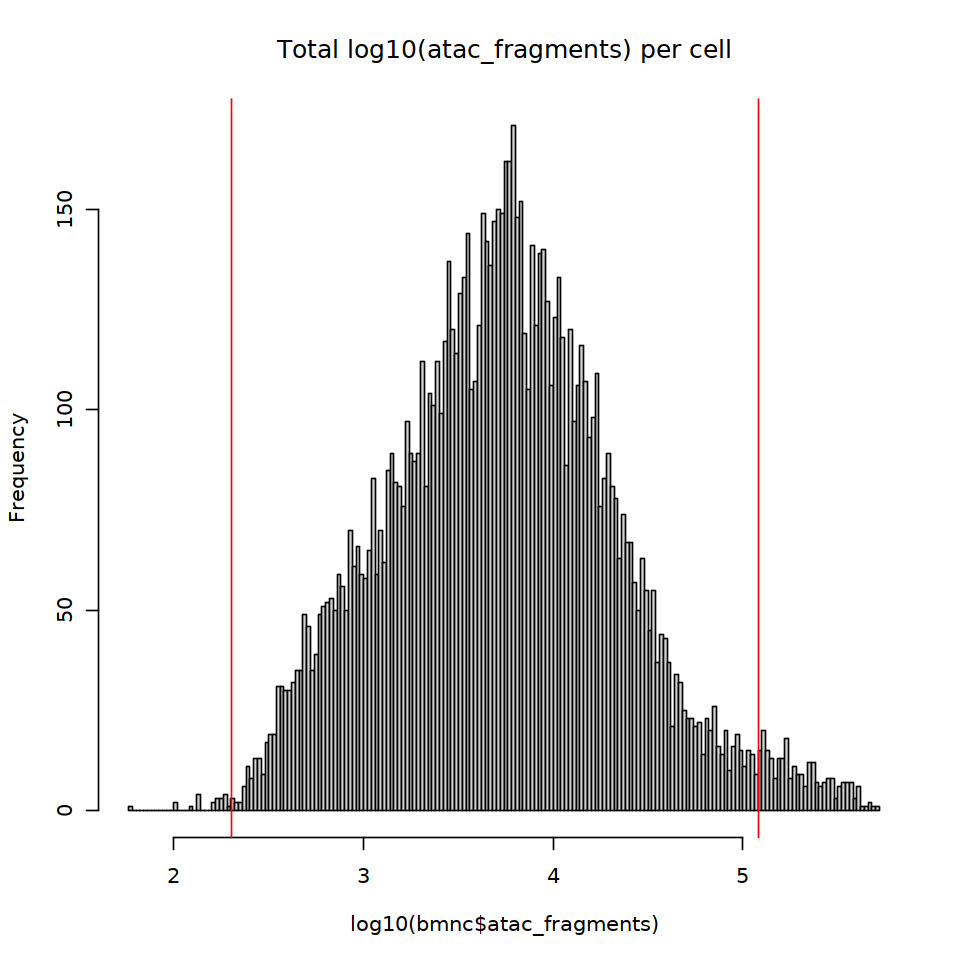

In [53]:
hist(log10(bmnc$atac_fragments), breaks = 150,
    main = 'Total log10(atac_fragments) per cell')
abline(v=log10(lower_totfraq_thresh), col = 'red')
abline(v=log10(upper_totfraq_thresh), col = 'red')

[1] "Removes 21 cells"


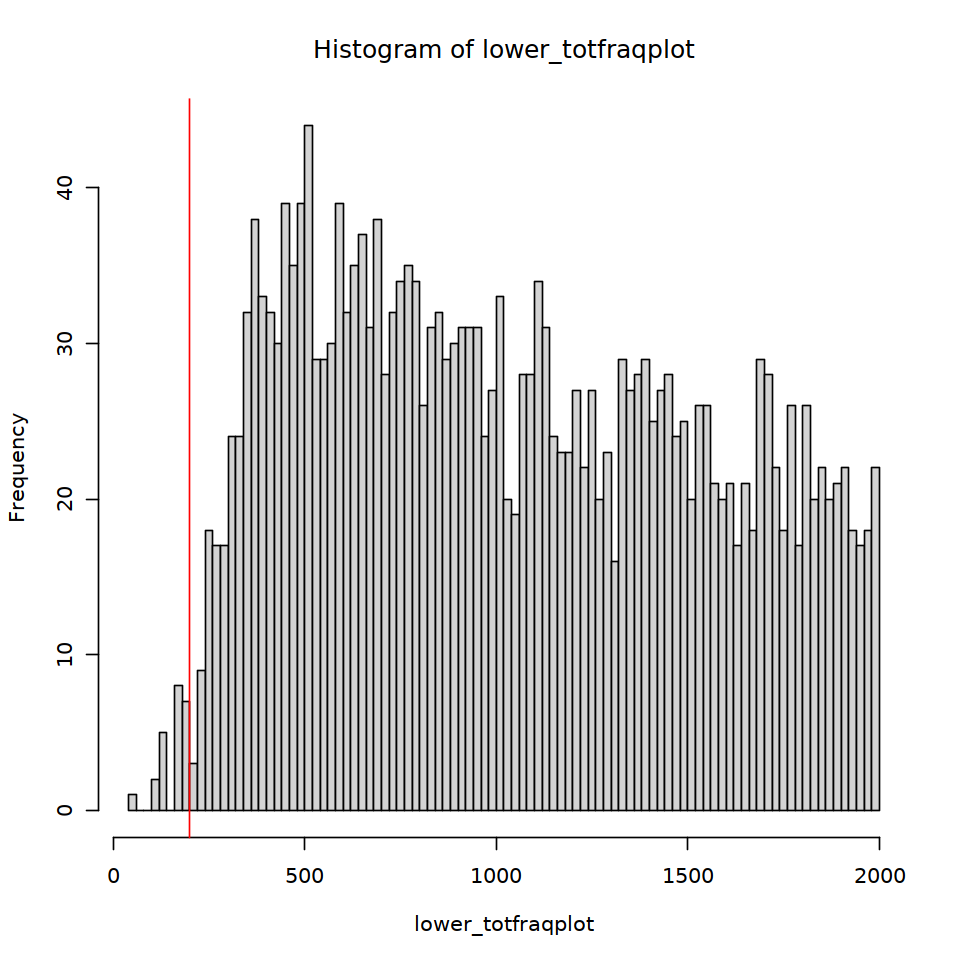

In [54]:
print(paste('Removes', as.character(sum(bmnc$atac_fragments < lower_totfraq_thresh)),'cells'))
hist(lower_totfraqplot, breaks = 100)
abline(v=lower_totfraq_thresh, col = 'red')

[1] "Removes 264 cells"


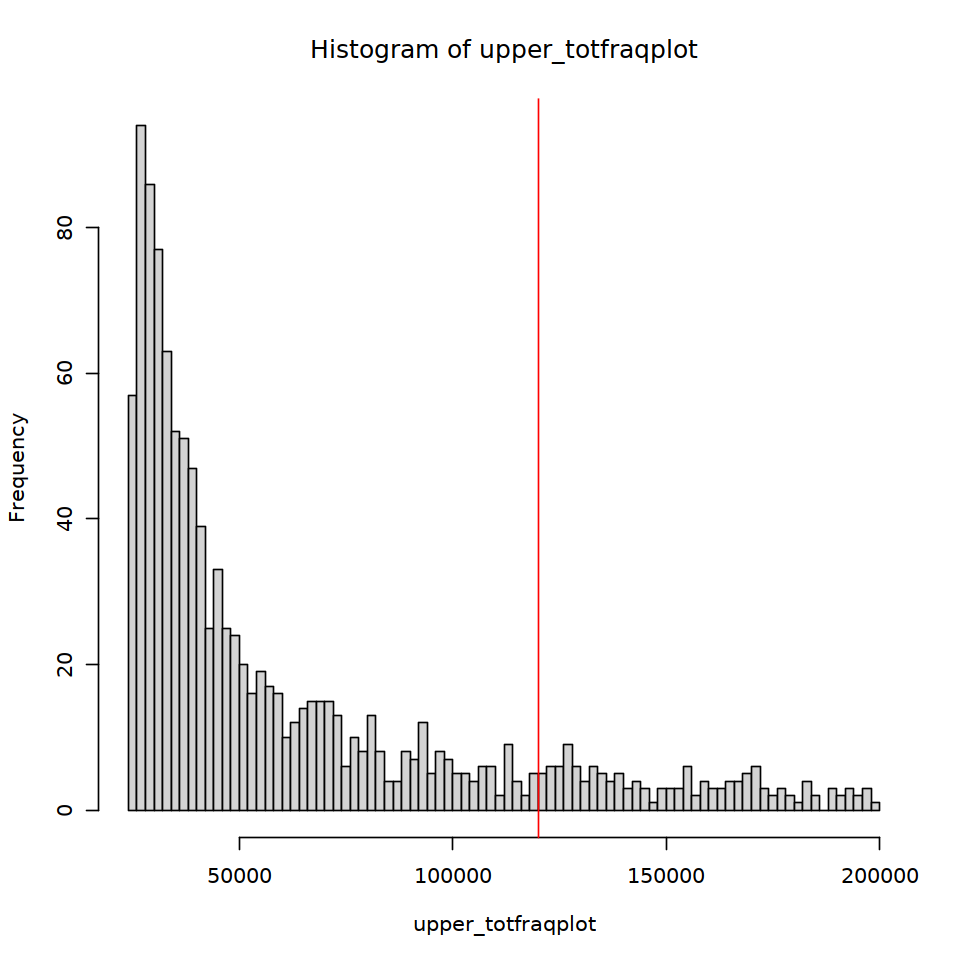

In [55]:
print(paste('Removes', as.character(sum(bmnc$atac_fragments > upper_totfraq_thresh)),'cells'))
hist(upper_totfraqplot, breaks = 100)
abline(v=upper_totfraq_thresh, col = 'red')

#### TSS enrichment

We don't consider a high TSS score as problematic, so we only filter for low and extreme high outliers

In [65]:
lower_tss_thresh = 2.2
upper_tss_thresh = 10.5

In [66]:
lower_tssplot <- bmnc$TSS.enrichment[bmnc$TSS.enrichment < 6]
upper_tssplot <- bmnc$TSS.enrichment[bmnc$TSS.enrichment > 5]

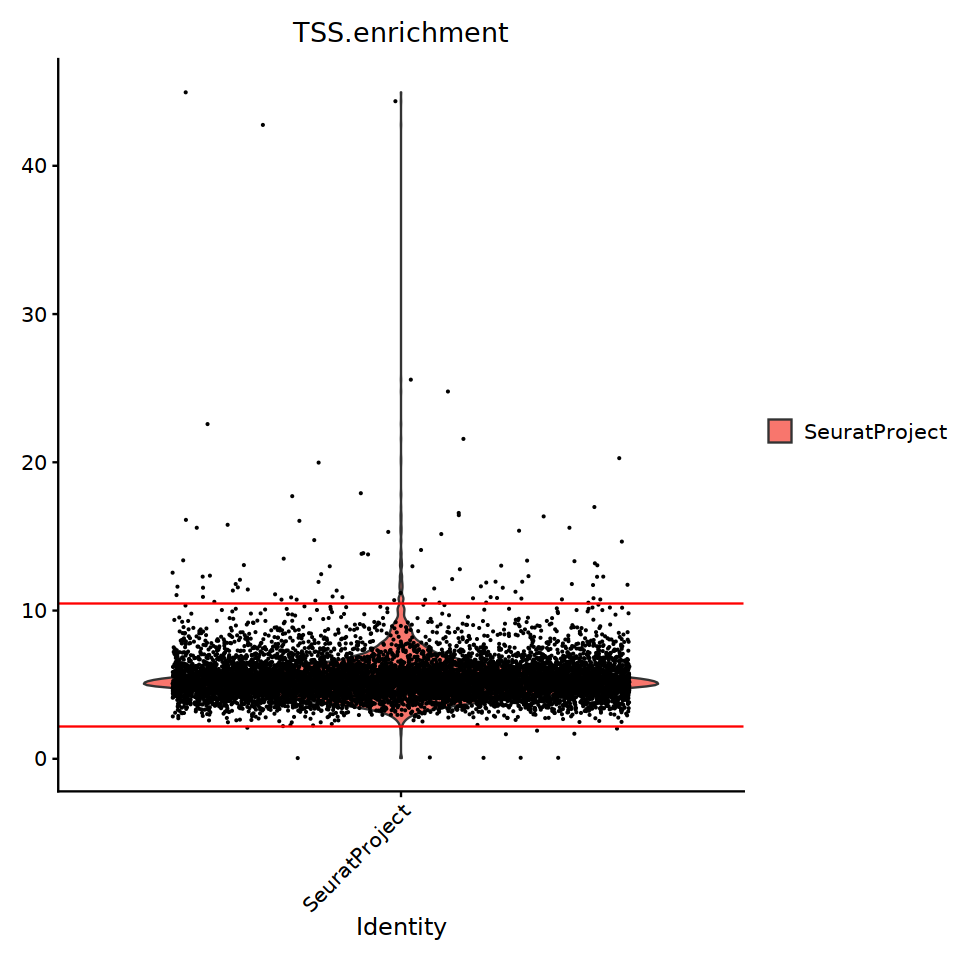

In [67]:
options(repr.plot.width=8, repr.plot.height=8) # figure size

v_plot <- VlnPlot(
    object = bmnc,
    features = c('TSS.enrichment'),
    pt.size = 0.1,
    ncol = 1,
)

v_plot + 
geom_hline(yintercept=lower_tss_thresh, color='red') +
geom_hline(yintercept=upper_tss_thresh, color='red') 

[1] "Removes 10 cells"


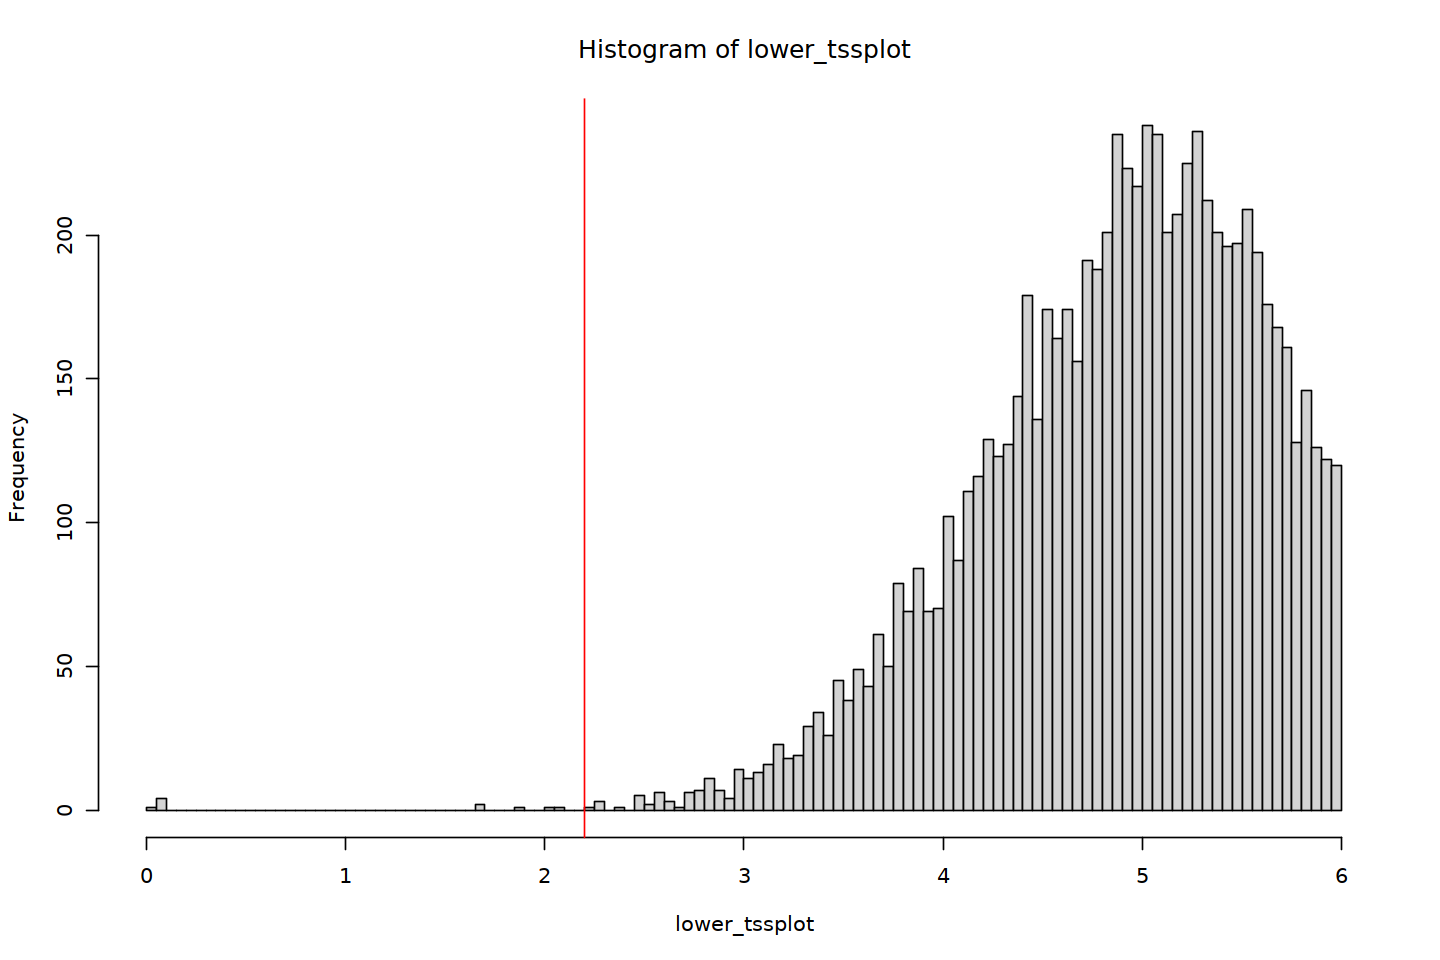

In [68]:
print(paste('Removes', as.character(sum(bmnc$TSS.enrichment < lower_tss_thresh)),'cells'))

options(repr.plot.width=12, repr.plot.height=8) # figure size

hist(lower_tssplot, breaks = 100)
abline(v=lower_tss_thresh, col = 'red')


[1] "Removes 90 cells"


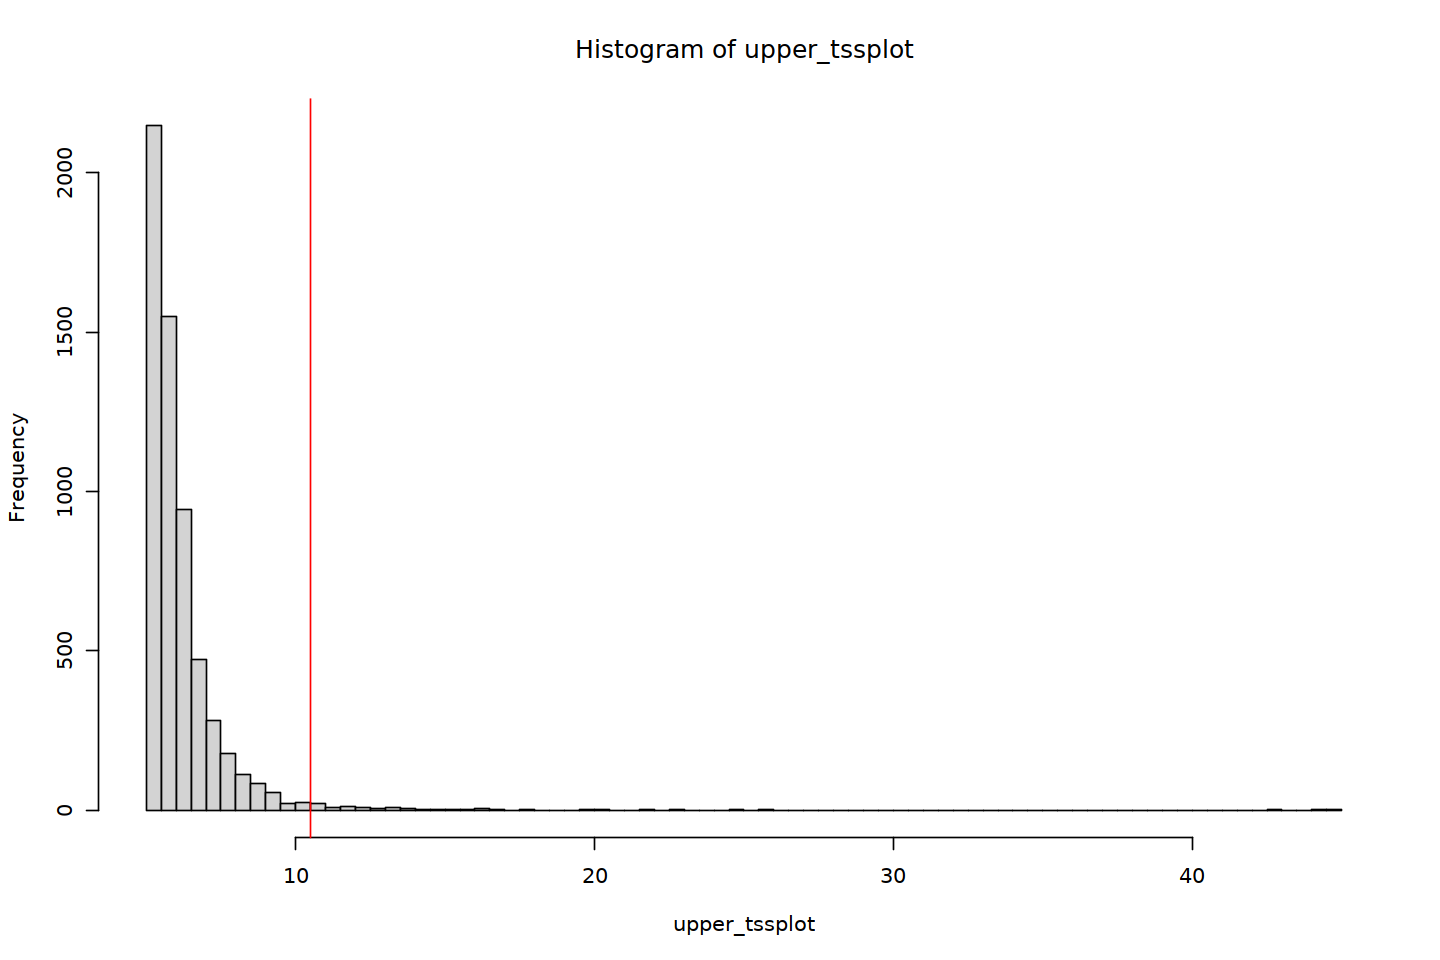

In [69]:
print(paste('Removes', as.character(sum(bmnc$TSS.enrichment > upper_tss_thresh)),'cells'))

options(repr.plot.width=12, repr.plot.height=8) # figure size

hist(upper_tssplot, breaks = 100)
abline(v=upper_tss_thresh, col = 'red')


#### Fraction of reads within peaks

Only remove lower tip

In [102]:
lower_in_peak_frac_thresh = 0.455

In [103]:
lower_in_peak_frac_plot <- bmnc$reads_in_peaks_frac[bmnc$reads_in_peaks_frac < 0.5]

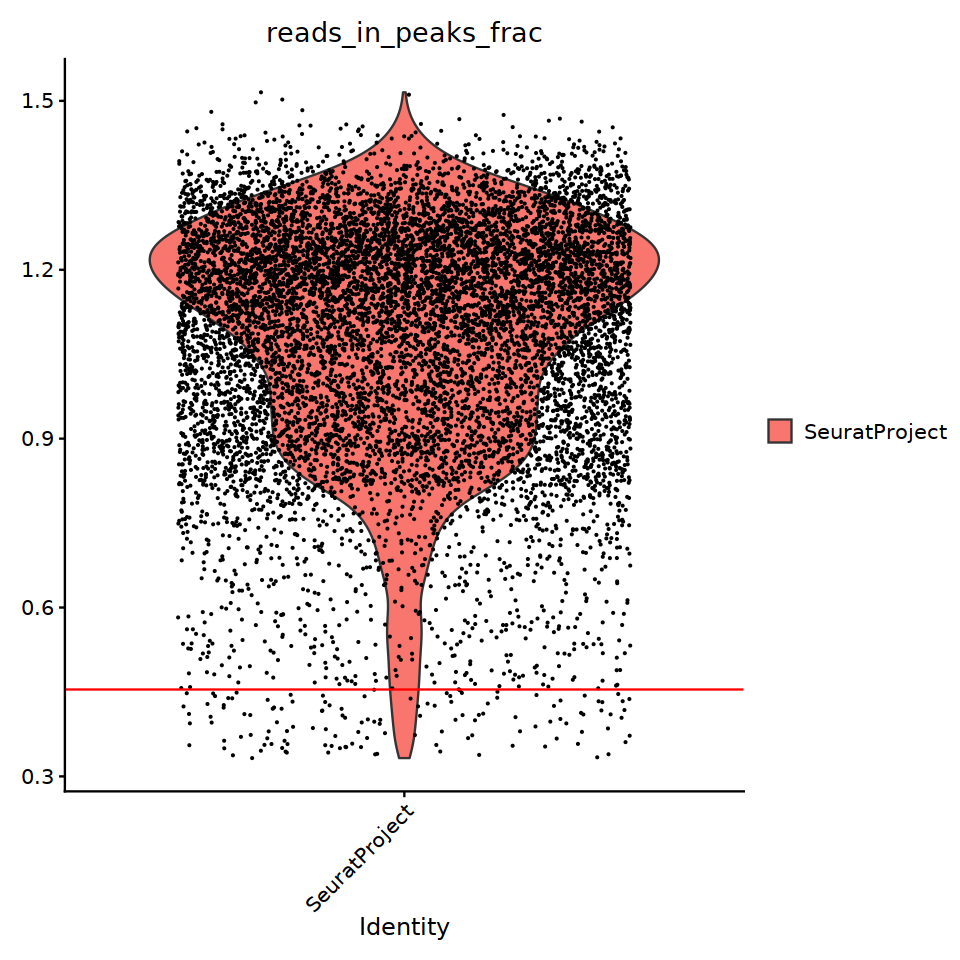

In [104]:
options(repr.plot.width=8, repr.plot.height=8) # figure size

v_plot <- VlnPlot(
    object = bmnc,
    features = c('reads_in_peaks_frac'),
    pt.size = 0.1,
    ncol = 1,
)

v_plot + 
geom_hline(yintercept=lower_in_peak_frac_thresh, color='red') 

[1] "Removes 130 cells"


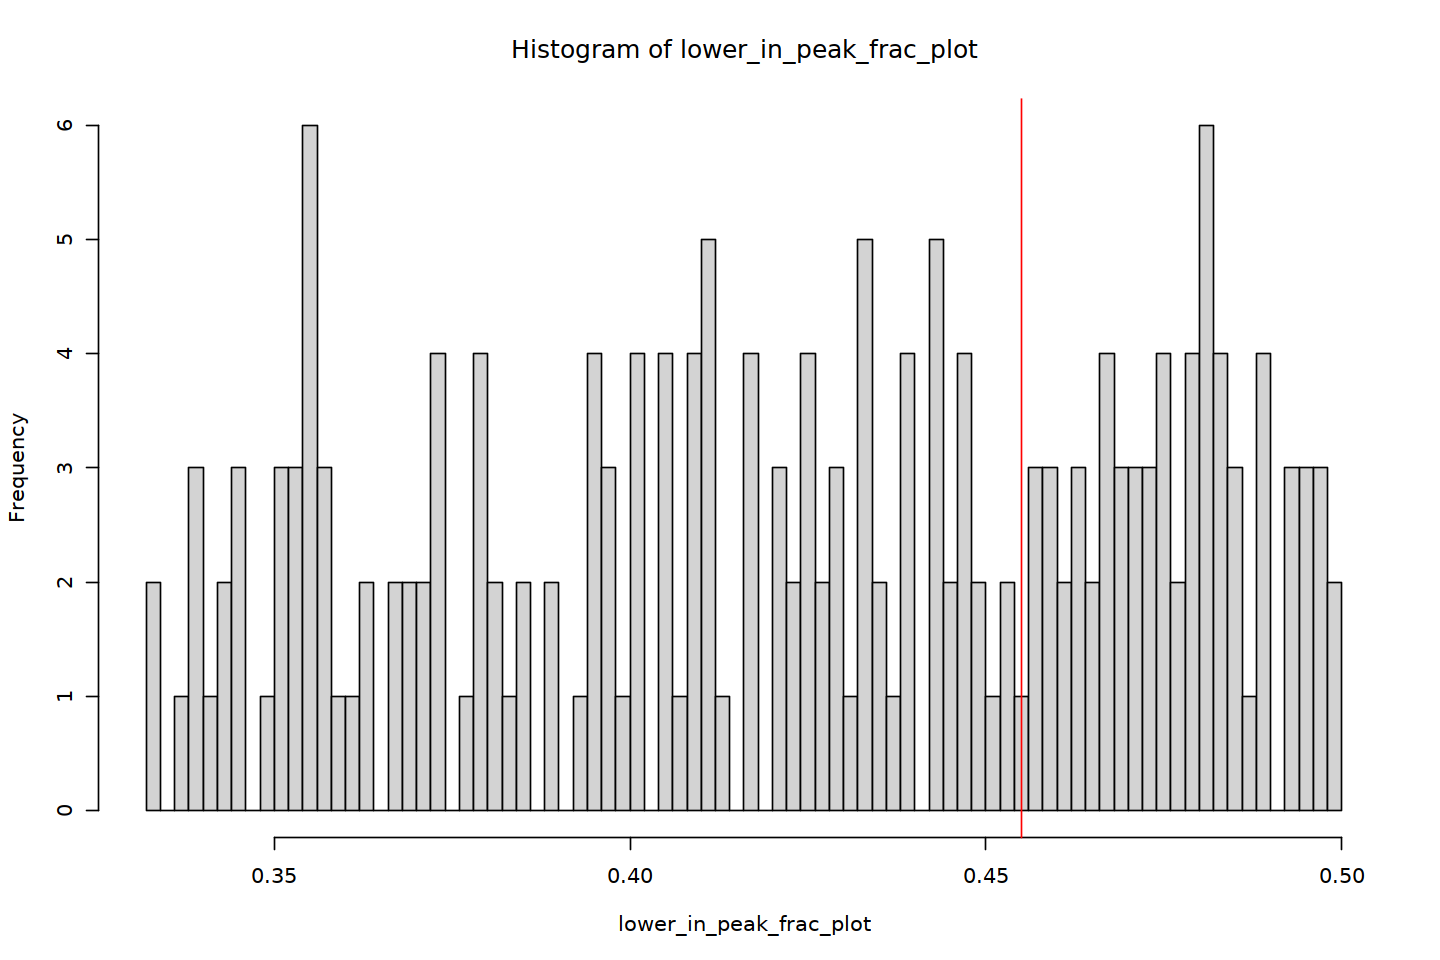

In [105]:
print(paste('Removes', as.character(sum(bmnc$reads_in_peaks_frac < lower_in_peak_frac_thresh)),'cells'))

options(repr.plot.width=12, repr.plot.height=8) # figure size

hist(lower_in_peak_frac_plot, breaks = 100)
abline(v=lower_in_peak_frac_thresh, col = 'red')


#### Blacklist fraction

Only remove upper tail

In [74]:
upper_bl_thresh = 0.0095#126

In [75]:
upper_bl_plot <- bmnc$blacklist_fraction[bmnc$blacklist_fraction > 0.005 & bmnc$blacklist_fraction < 0.03]

Warning message:
“Removed 3 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 3 rows containing missing values (geom_point).”


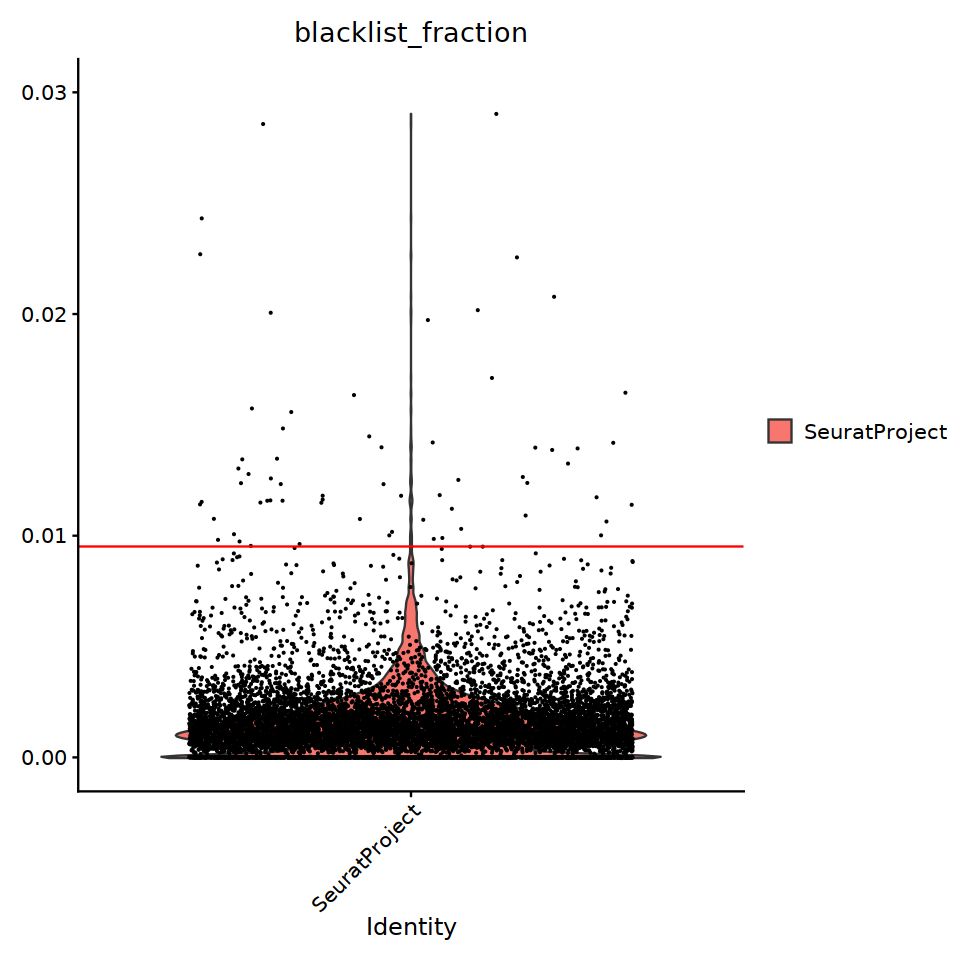

In [76]:
options(repr.plot.width=8, repr.plot.height=8) # figure size

v_plot <- VlnPlot(
    object = bmnc,
    features = c('blacklist_fraction'),
    pt.size = 0.1,
    ncol = 1,
    y.max = 0.03
)

v_plot + 
geom_hline(yintercept=upper_bl_thresh, color='red') 

[1] "Removes 68 cells"


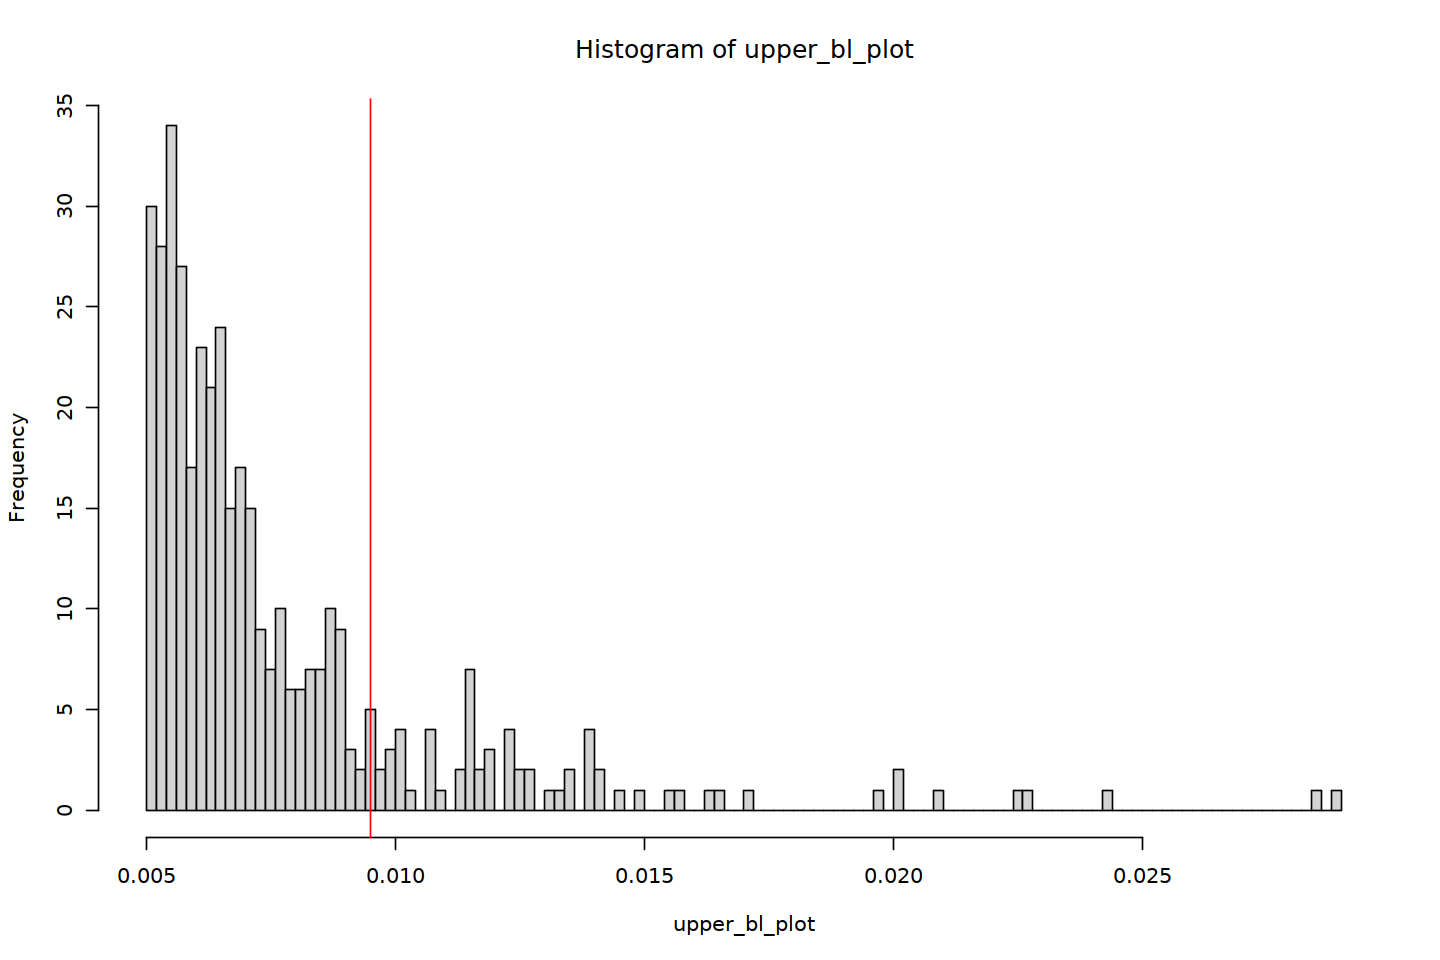

In [77]:
print(paste('Removes', as.character(sum(bmnc$blacklist_fraction > upper_bl_thresh)),'cells'))

options(repr.plot.width=12, repr.plot.height=8) # figure size

hist(upper_bl_plot, breaks = 100)
abline(v=upper_bl_thresh, col = 'red')


#### Nucleosome signal

Only remove upper tail

In [86]:
upper_ns_thresh = 2.4

In [87]:
upper_ns_plot <- bmnc$nucleosome_signal[bmnc$nucleosome_signal > 0.9]

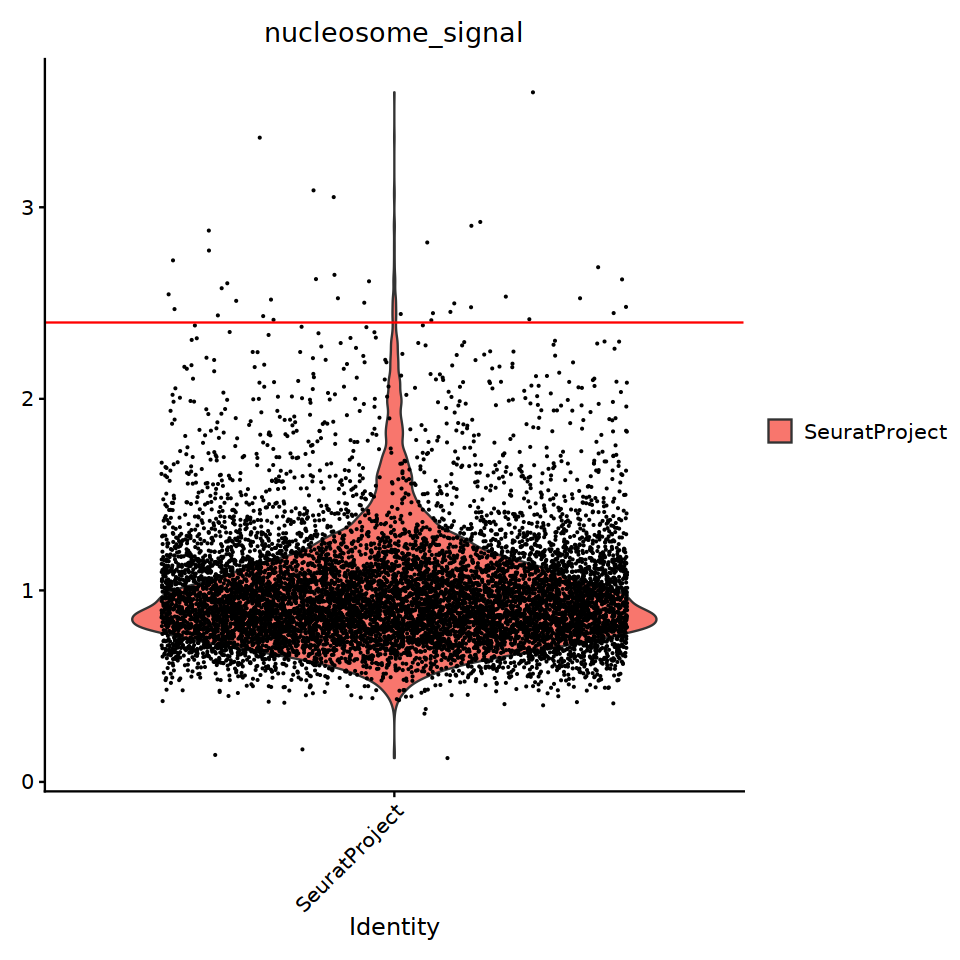

In [88]:
options(repr.plot.width=8, repr.plot.height=8) # figure size

v_plot <- VlnPlot(
    object = bmnc,
    features = c('nucleosome_signal'),
    pt.size = 0.1,
    ncol = 1
)

v_plot + 
geom_hline(yintercept=upper_ns_thresh, color='red') 

[1] "Removes 37 cells"


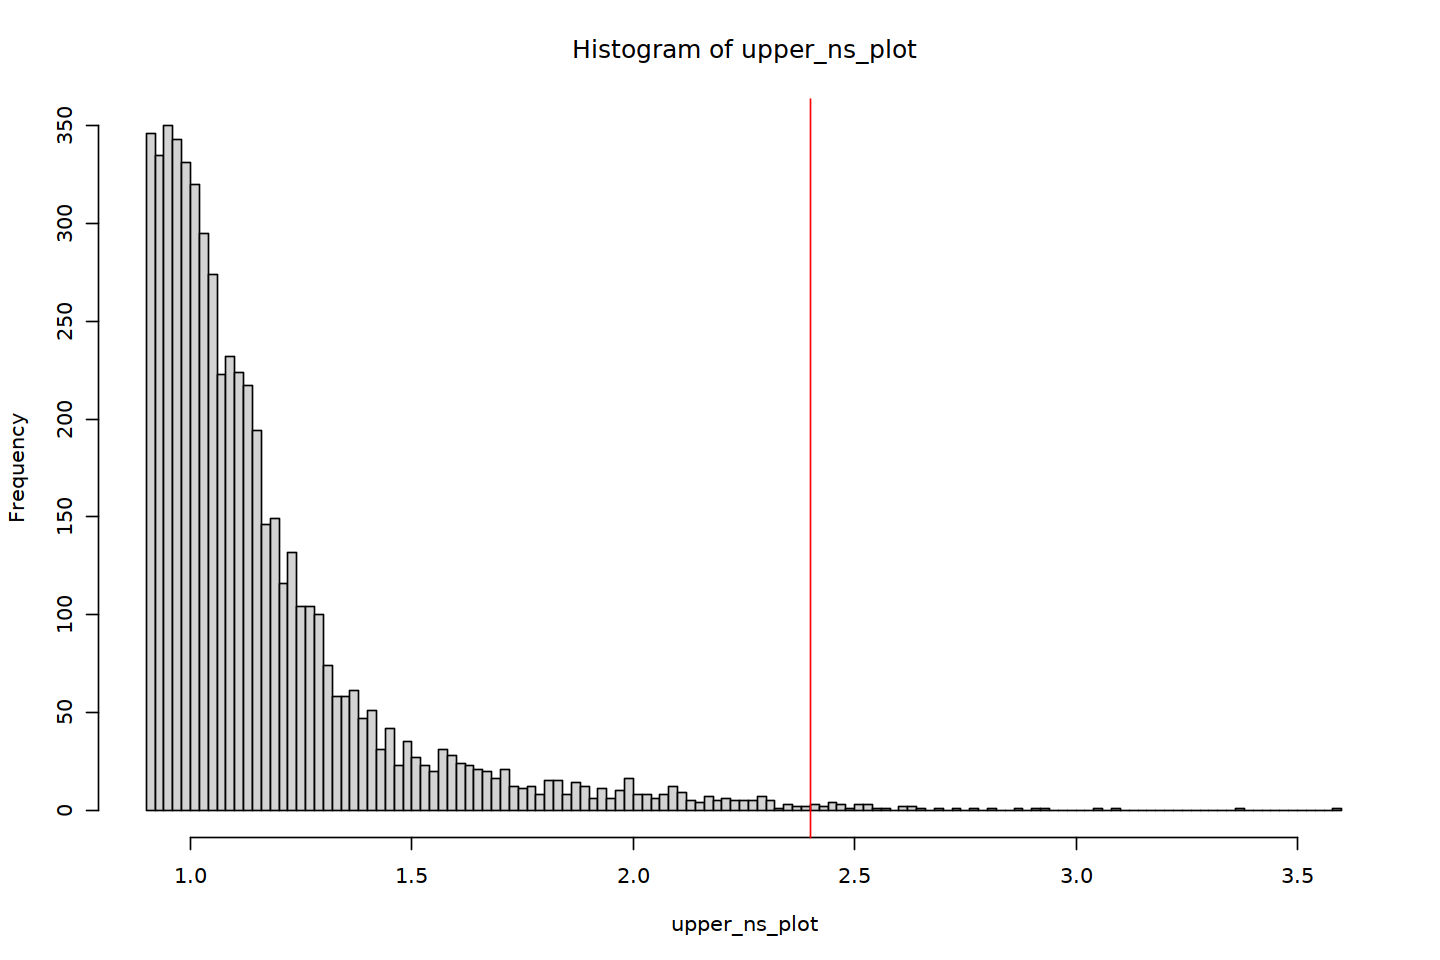

In [89]:
print(paste('Removes', as.character(sum(bmnc$nucleosome_signal > upper_ns_thresh)),'cells'))

options(repr.plot.width=12, repr.plot.height=8) # figure size

hist(upper_ns_plot, breaks = 100)
abline(v=upper_ns_thresh, col = 'red')


## Filter cells

To see how many cells are filtered after each step, the filters are applied sequentially.

In [106]:
# First filter bmnc object

n_before <- ncol(bmnc)
print(paste('Number of cells before filter step:', n_before))

bmnc_filtered <- subset(
    x = bmnc,
    subset = atac_fragments > lower_totfraq_thresh
)

n_after <- ncol(bmnc_filtered)
print(paste('Number of cells after filter step:', n_after))
print(paste('Percent removed', round((1 - n_after / n_before) * 100, 2),
            '% (', n_before - n_after, ')'))

[1] "Number of cells before filter step: 10062"
[1] "Number of cells after filter step: 10039"
[1] "Percent removed 0.23 % ( 23 )"


In [107]:
# Then use filtered object for subsequent filtering

n_before <- ncol(bmnc_filtered)
print(paste('Number of cells before filter step:', n_before))

bmnc_filtered <- subset(
    x = bmnc_filtered,
    subset = atac_fragments < upper_totfraq_thresh
)

n_after <- ncol(bmnc_filtered)
print(paste('Number of cells after filter step:', n_after))
print(paste('Percent removed', round((1 - n_after / n_before) * 100, 2),
            '% (', n_before - n_after, ')'))

[1] "Number of cells before filter step: 10039"
[1] "Number of cells after filter step: 9775"
[1] "Percent removed 2.63 % ( 264 )"


In [108]:
# TSS.enrichment

n_before <- ncol(bmnc_filtered)
print(paste('Number of cells before filter step:', n_before))

bmnc_filtered <- subset(
    x = bmnc_filtered,
    subset = TSS.enrichment > lower_tss_thresh &
        TSS.enrichment < upper_tss_thresh
)

n_after <- ncol(bmnc_filtered)
print(paste('Number of cells after filter step:', n_after))
print(paste('Percent removed', round((1 - n_after / n_before) * 100, 2),
            '% (', n_before - n_after, ')'))

[1] "Number of cells before filter step: 9775"
[1] "Number of cells after filter step: 9683"
[1] "Percent removed 0.94 % ( 92 )"


In [109]:
# reads_in_peaks_frac

n_before <- ncol(bmnc_filtered)
print(paste('Number of cells before filter step:', n_before))

bmnc_filtered <- subset(
    x = bmnc_filtered,
    subset = reads_in_peaks_frac > lower_in_peak_frac_thresh
)

n_after <- ncol(bmnc_filtered)
print(paste('Number of cells after filter step:', n_after))
print(paste('Percent removed', round((1 - n_after / n_before) * 100, 2),
            '% (', n_before - n_after, ')'))

[1] "Number of cells before filter step: 9683"
[1] "Number of cells after filter step: 9571"
[1] "Percent removed 1.16 % ( 112 )"


In [110]:
# blacklist_fraction

n_before <- ncol(bmnc_filtered)
print(paste('Number of cells before filter step:', n_before))

bmnc_filtered <- subset(
    x = bmnc_filtered,
    subset = blacklist_fraction < upper_bl_thresh
)

n_after <- ncol(bmnc_filtered)
print(paste('Number of cells after filter step:', n_after))
print(paste('Percent removed', round((1 - n_after / n_before) * 100, 2),
            '% (', n_before - n_after, ')'))

[1] "Number of cells before filter step: 9571"
[1] "Number of cells after filter step: 9531"
[1] "Percent removed 0.42 % ( 40 )"


In [111]:
# reads_in_peaks_frac

n_before <- ncol(bmnc_filtered)
print(paste('Number of cells before filter step:', n_before))

bmnc_filtered <- subset(
    x = bmnc_filtered,
    subset = nucleosome_signal < upper_ns_thresh
)

n_after <- ncol(bmnc_filtered)
print(paste('Number of cells after filter step:', n_after))
print(paste('Percent removed', round((1 - n_after / n_before) * 100, 2),
            '% (', n_before - n_after, ')'))

[1] "Number of cells before filter step: 9531"
[1] "Number of cells after filter step: 9527"
[1] "Percent removed 0.04 % ( 4 )"


In [112]:
print(paste('Percent cells removed (total):', round((1-ncol(bmnc_filtered) / ncol(bmnc)) * 100, 2), '%'))

[1] "Percent cells removed (total): 5.32 %"


## Dimensionality reduction via LSI

Perfom latent sematic indexing (LSI) by generating term frequencies and SVD on these. LSI is adapted from NLP to identify similar documents. See some further details here: https://en.wikipedia.org/wiki/Latent_semantic_analysis#Latent_semantic_indexing


In [113]:
bmnc_filtered <- RunTFIDF(bmnc_filtered)

Performing TF-IDF normalization



In [114]:
bmnc_filtered <- FindTopFeatures(bmnc_filtered, min.cutoff = 'q0')

In [115]:
bmnc_filtered <- RunSVD(bmnc_filtered)

Running SVD

Scaling cell embeddings



In [116]:
options(repr.plot.width=16, repr.plot.height=9)

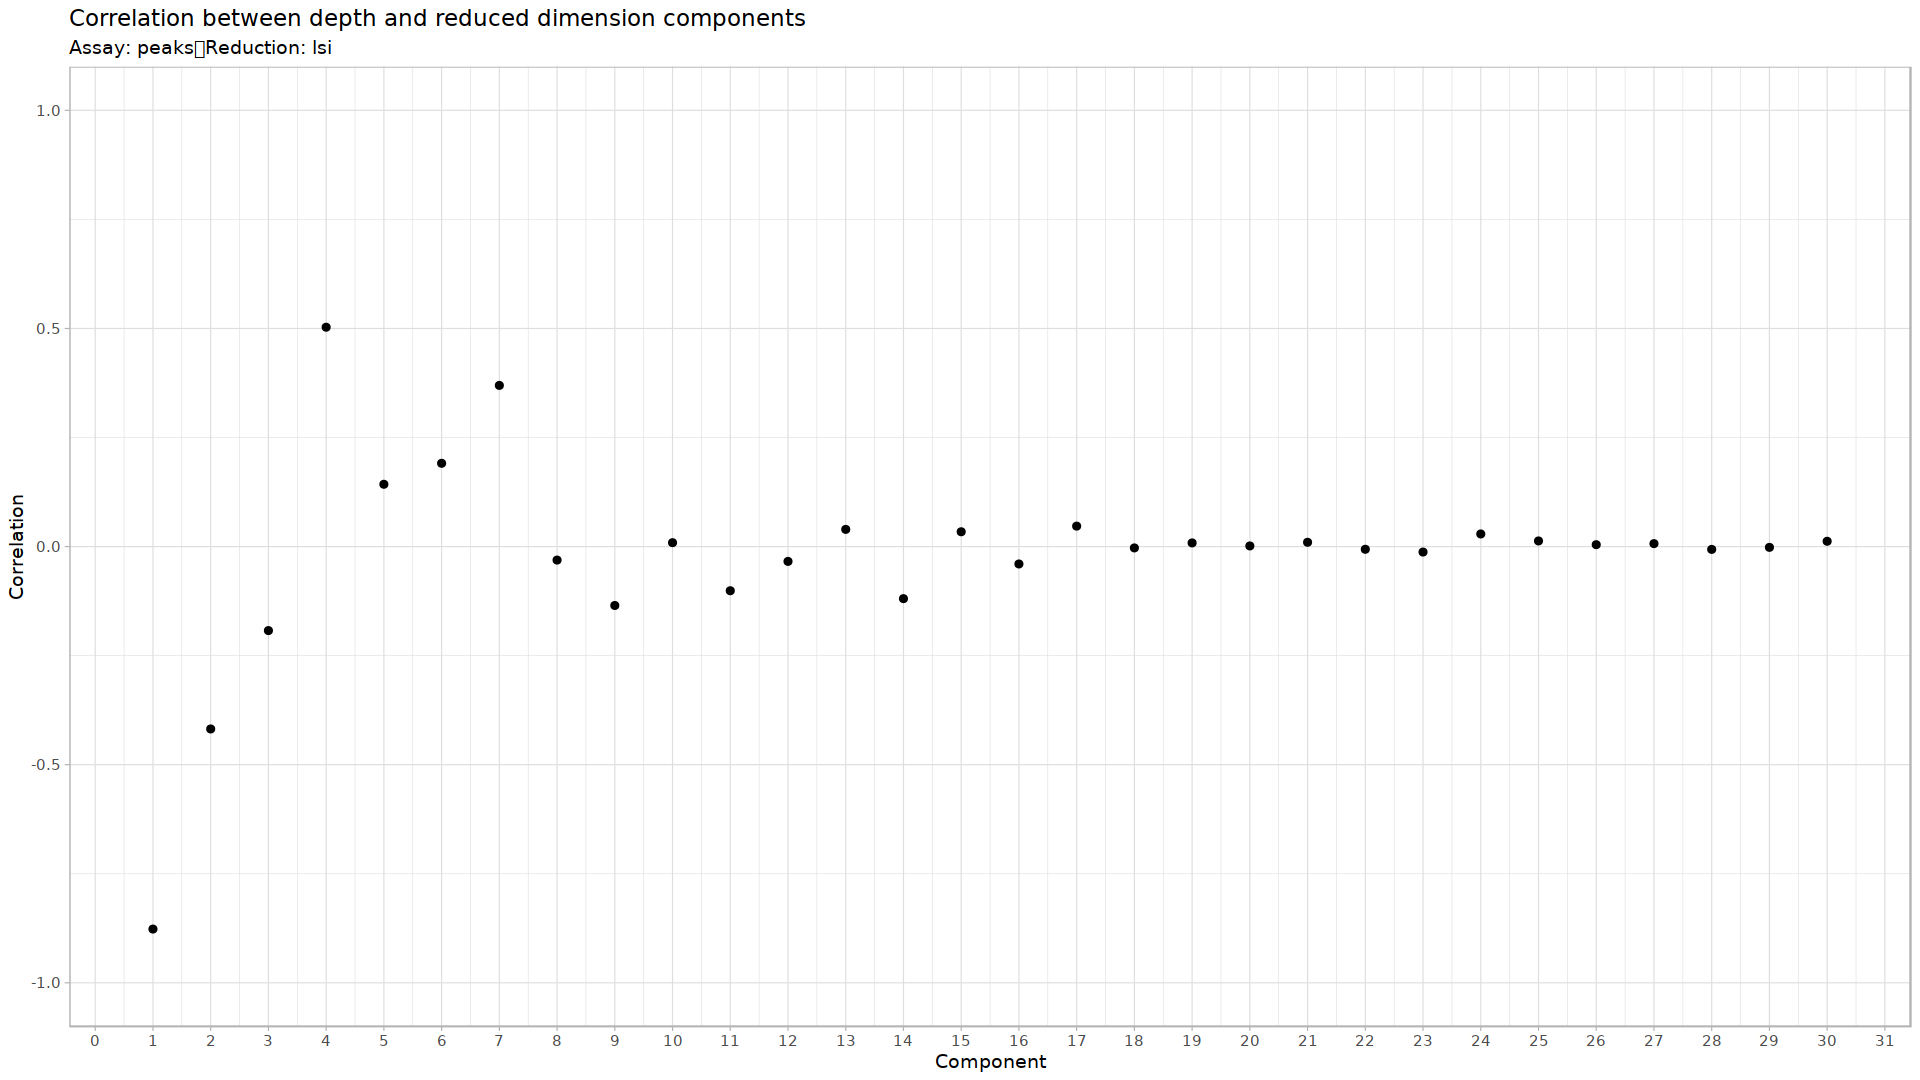

In [117]:
DepthCor(bmnc_filtered, n=30) 

**^^Plot above:** The first and sometimes few more LSI components are highly correlated to the total fragment count per cell (here, also refered to as sequencing depth). For downstream processing we would like to remove these components and work with the variance captured by the remaining components. In the plot below, the first component is nearly perfectly correlated with the sequencing depth per cell. Also the 4th component might be good to be removed.

## Save intermediate output

In [118]:
saveRDS(bmnc_filtered, file ='data/bmnc_fltr.rds')

#bmnc_filtered <- loadRDS(file ='data/multiome/proc_data/s1d1/bmnc_fltr.rds')

## Remove LSI components

To test the effect on the downstream processing, we create a neighborhood graph based on the components not correlated with the sequencing depth, cluster the cells and visualize our qc metrics on the data.

The goal is to remove LSI components that are highly correlated with the total number of fragments while keeping as much structure as possible.

For illustration purpose, we also perform clustering using all components. One can nicely see how this is driven by the number of atac_fragments (especially low counts).

Further points to consider when choosing components to remove:
- Often removing 1 or 2 components is enough
- A high count cluster might correlate with doublets, so removing all total count-driven variation can make separation of doublets/low quality cells more difficult (See plot with 1st, 2nd and 4th component removed)
- 50 LSI components were generated, 30 - 45 should be sufficient to include in total
- Despite removing total count-related LSI components, it is expected to see a high and/or low count cluster that might be sprinkeld across the UMAP. This we need to take care of during annotation (ATAC notebook part 2).


### With all components

In [119]:
# Defining, which components to keep:
dims_to_use <- c(1:40)

In [120]:
bmnc_fltr_all <- suppressMessages(RunUMAP(object = bmnc_filtered, reduction = 'lsi', dims = dims_to_use))

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


In [121]:
bmnc_fltr_all <- FindNeighbors(object = bmnc_fltr_all, reduction = 'lsi', dims = dims_to_use)

Computing nearest neighbor graph

Computing SNN



In [122]:
bmnc_fltr_all <- FindClusters(object = bmnc_fltr_all, verbose = FALSE, algorithm = 3)

In [123]:
options(repr.plot.width=24, repr.plot.height=12)

In [124]:
dimplot1 <- DimPlot(object = bmnc_fltr_all, label = TRUE) + NoLegend()

In [125]:
peak_frac_pl <- FeaturePlot(
  object = bmnc_fltr_all,
  features = 'atac_fragments',
  pt.size = 0.1
) + ggtitle("atac_fragments - high counts highlighted")

In [126]:
peak_frac_low_pl <- FeaturePlot(
  object = bmnc_fltr_all,
  features = 'atac_fragments',
  pt.size = 0.1,
  max.cutoff=3000,
  cols = c("darkred", "lightgrey")
) + ggtitle("atac_fragments - low counts highlighted")

In [127]:
tss_pl <- FeaturePlot(
  object = bmnc_fltr_all,
  features = 'TSS.enrichment',
  pt.size = 0.1,
  max.cutoff=6,
  cols = c("darkred", "lightgrey")
)

In [128]:
per_in_peak_pl <- FeaturePlot(
  object = bmnc_fltr_all,
  features = 'reads_in_peaks_frac',
  pt.size = 0.1,
  max.cutoff=0.6,
  cols = c("darkred", "lightgrey")
)

In [129]:
bl_pl <- FeaturePlot(
  object = bmnc_fltr_all,
  features = 'blacklist_fraction',
  pt.size = 0.1,
  max.cutoff=0.01
) 

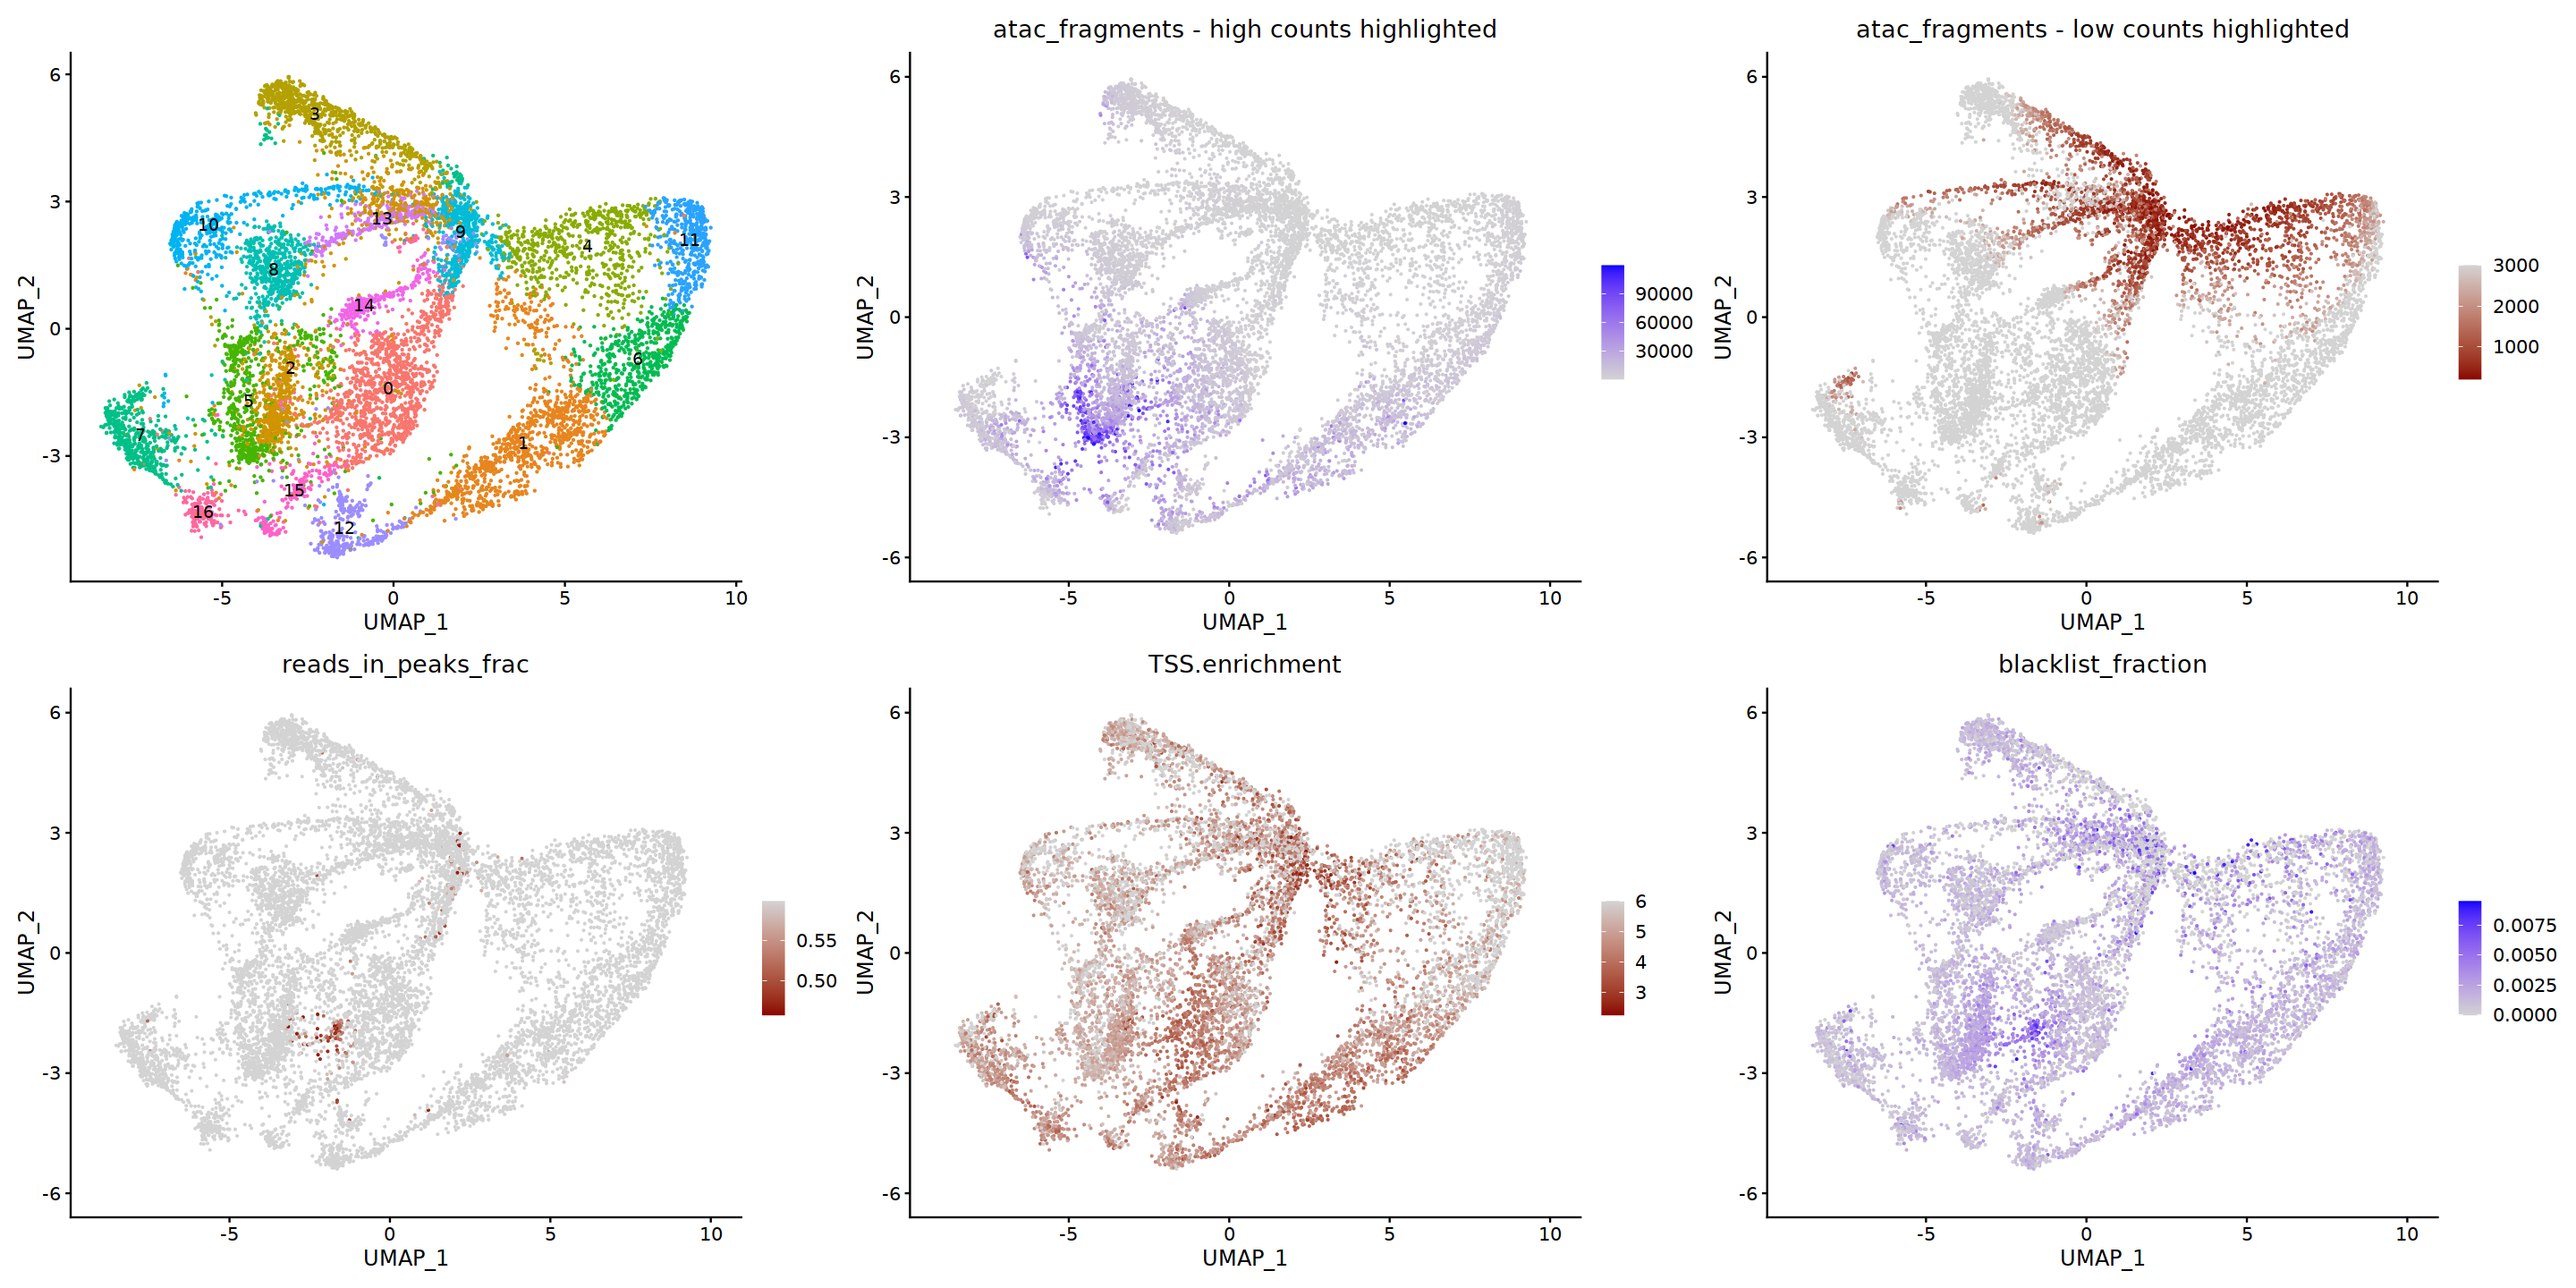

In [130]:
dimplot1 + peak_frac_pl + peak_frac_low_pl + per_in_peak_pl + tss_pl + bl_pl

**^^Plot above:** Structure mainly driven by total counts (small number of counts)

### Removing only the first component

In [131]:
# Defining, which components to keep:
dims_to_use <- c(2:40)

In [132]:
bmnc_fltr_1 <- suppressMessages(RunUMAP(object = bmnc_filtered, reduction = 'lsi', dims = dims_to_use))

In [133]:
bmnc_fltr_1 <- FindNeighbors(object = bmnc_fltr_1, reduction = 'lsi', dims = dims_to_use)

Computing nearest neighbor graph

Computing SNN



In [134]:
bmnc_fltr_1 <- FindClusters(object = bmnc_fltr_1, verbose = FALSE, algorithm = 3)

In [135]:
options(repr.plot.width=24, repr.plot.height=12)

In [136]:
dimplot1 <- DimPlot(object = bmnc_fltr_1, label = TRUE) + NoLegend()

In [137]:
peak_frac_pl <- FeaturePlot(
  object = bmnc_fltr_1,
  features = 'atac_fragments',
  pt.size = 0.1,
  max.cutoff=100000
)

In [138]:
peak_frac_low_pl <- FeaturePlot(
  object = bmnc_fltr_1,
  features = 'atac_fragments',
  pt.size = 0.1,
  max.cutoff=4000,
  cols = c("darkred", "lightgrey")
)

In [139]:
tss_pl <- FeaturePlot(
  object = bmnc_fltr_1,
  features = 'TSS.enrichment',
  pt.size = 0.1,
  max.cutoff=6,
  cols = c("darkred", "lightgrey")
)

In [140]:
per_in_peak_pl <- FeaturePlot(
  object = bmnc_fltr_1,
  features = 'reads_in_peaks_frac',
  pt.size = 0.1,
  max.cutoff=0.6,
  cols = c("darkred", "lightgrey")
)

In [141]:
bl_pl <- FeaturePlot(
  object = bmnc_fltr_1,
  features = 'blacklist_fraction',
  pt.size = 0.1,
  max.cutoff=0.01
)

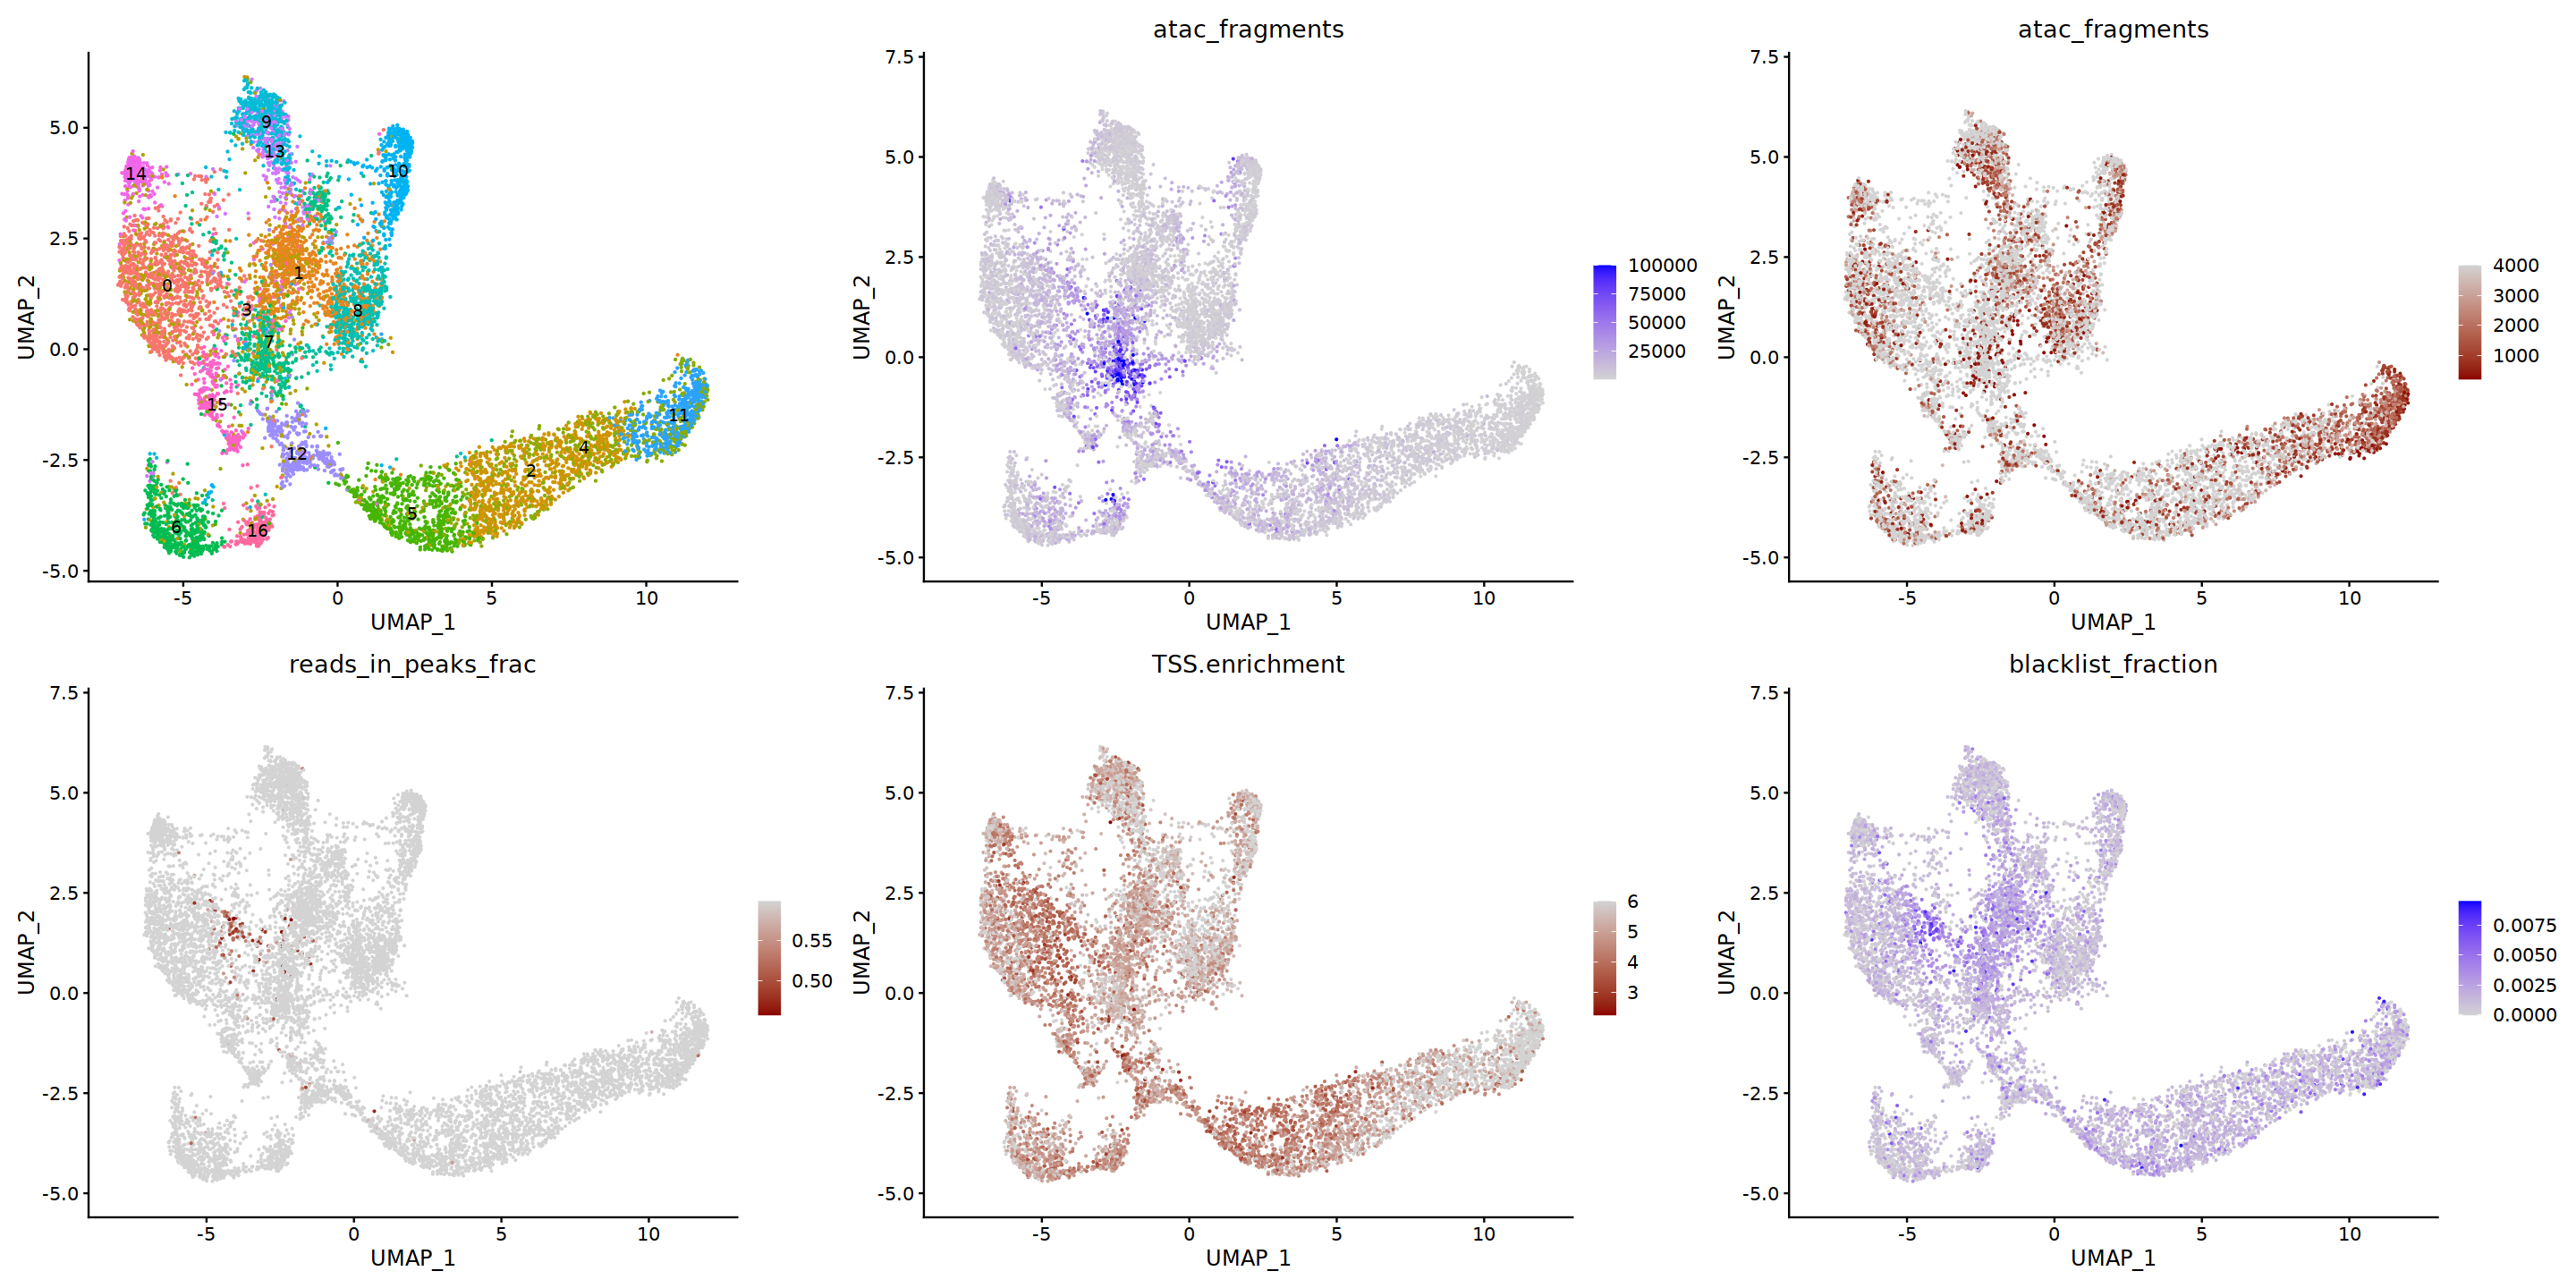

In [142]:
dimplot1 + peak_frac_pl + peak_frac_low_pl + per_in_peak_pl + tss_pl + bl_pl

**^^Plot above:** Clear structure; high count cluster present (9) that has some cells sprinkeld across the UMAP. This representation is used for downstrem processing, since it seems like single high count cells that might be doublets are rather assigned to cluster 9 and not merged with other clusters.

### Removing 1st and 4th component

In [143]:
# Defining, which components to keep:
dims_to_use <- c(2,3,5:40)

In [144]:
bmnc_fltr_1a4 <- suppressMessages(RunUMAP(object = bmnc_filtered, reduction = 'lsi', dims = dims_to_use))

In [145]:
bmnc_fltr_1a4 <- FindNeighbors(object = bmnc_fltr_1a4, reduction = 'lsi', dims = dims_to_use)

Computing nearest neighbor graph

Computing SNN



In [146]:
bmnc_fltr_1a4 <- FindClusters(object = bmnc_fltr_1a4, verbose = FALSE, algorithm = 3)

In [147]:
options(repr.plot.width=24, repr.plot.height=12)

In [148]:
dimplot1 <- DimPlot(object = bmnc_fltr_1a4, label = TRUE) + NoLegend()

In [149]:
peak_frac_pl <- FeaturePlot(
  object = bmnc_fltr_1a4,
  features = 'atac_fragments',
  pt.size = 0.1,
  max.cutoff=100000
)

In [150]:
peak_frac_low_pl <- FeaturePlot(
  object = bmnc_fltr_1a4,
  features = 'atac_fragments',
  pt.size = 0.1,
  max.cutoff=3000,
  cols = c("darkred", "lightgrey")
)

In [151]:
tss_pl <- FeaturePlot(
  object = bmnc_fltr_1a4,
  features = 'TSS.enrichment',
  pt.size = 0.1,
  max.cutoff=6,
  cols = c("darkred", "lightgrey")
)

In [152]:
per_in_peak_pl <- FeaturePlot(
  object = bmnc_fltr_1a4,
  features = 'reads_in_peaks_frac',
  pt.size = 0.1,
  max.cutoff=0.6,
  cols = c("darkred", "lightgrey")
)

In [153]:
bl_pl <- FeaturePlot(
  object = bmnc_fltr_1a4,
  features = 'blacklist_fraction',
  pt.size = 0.1,
  max.cutoff=0.01
)

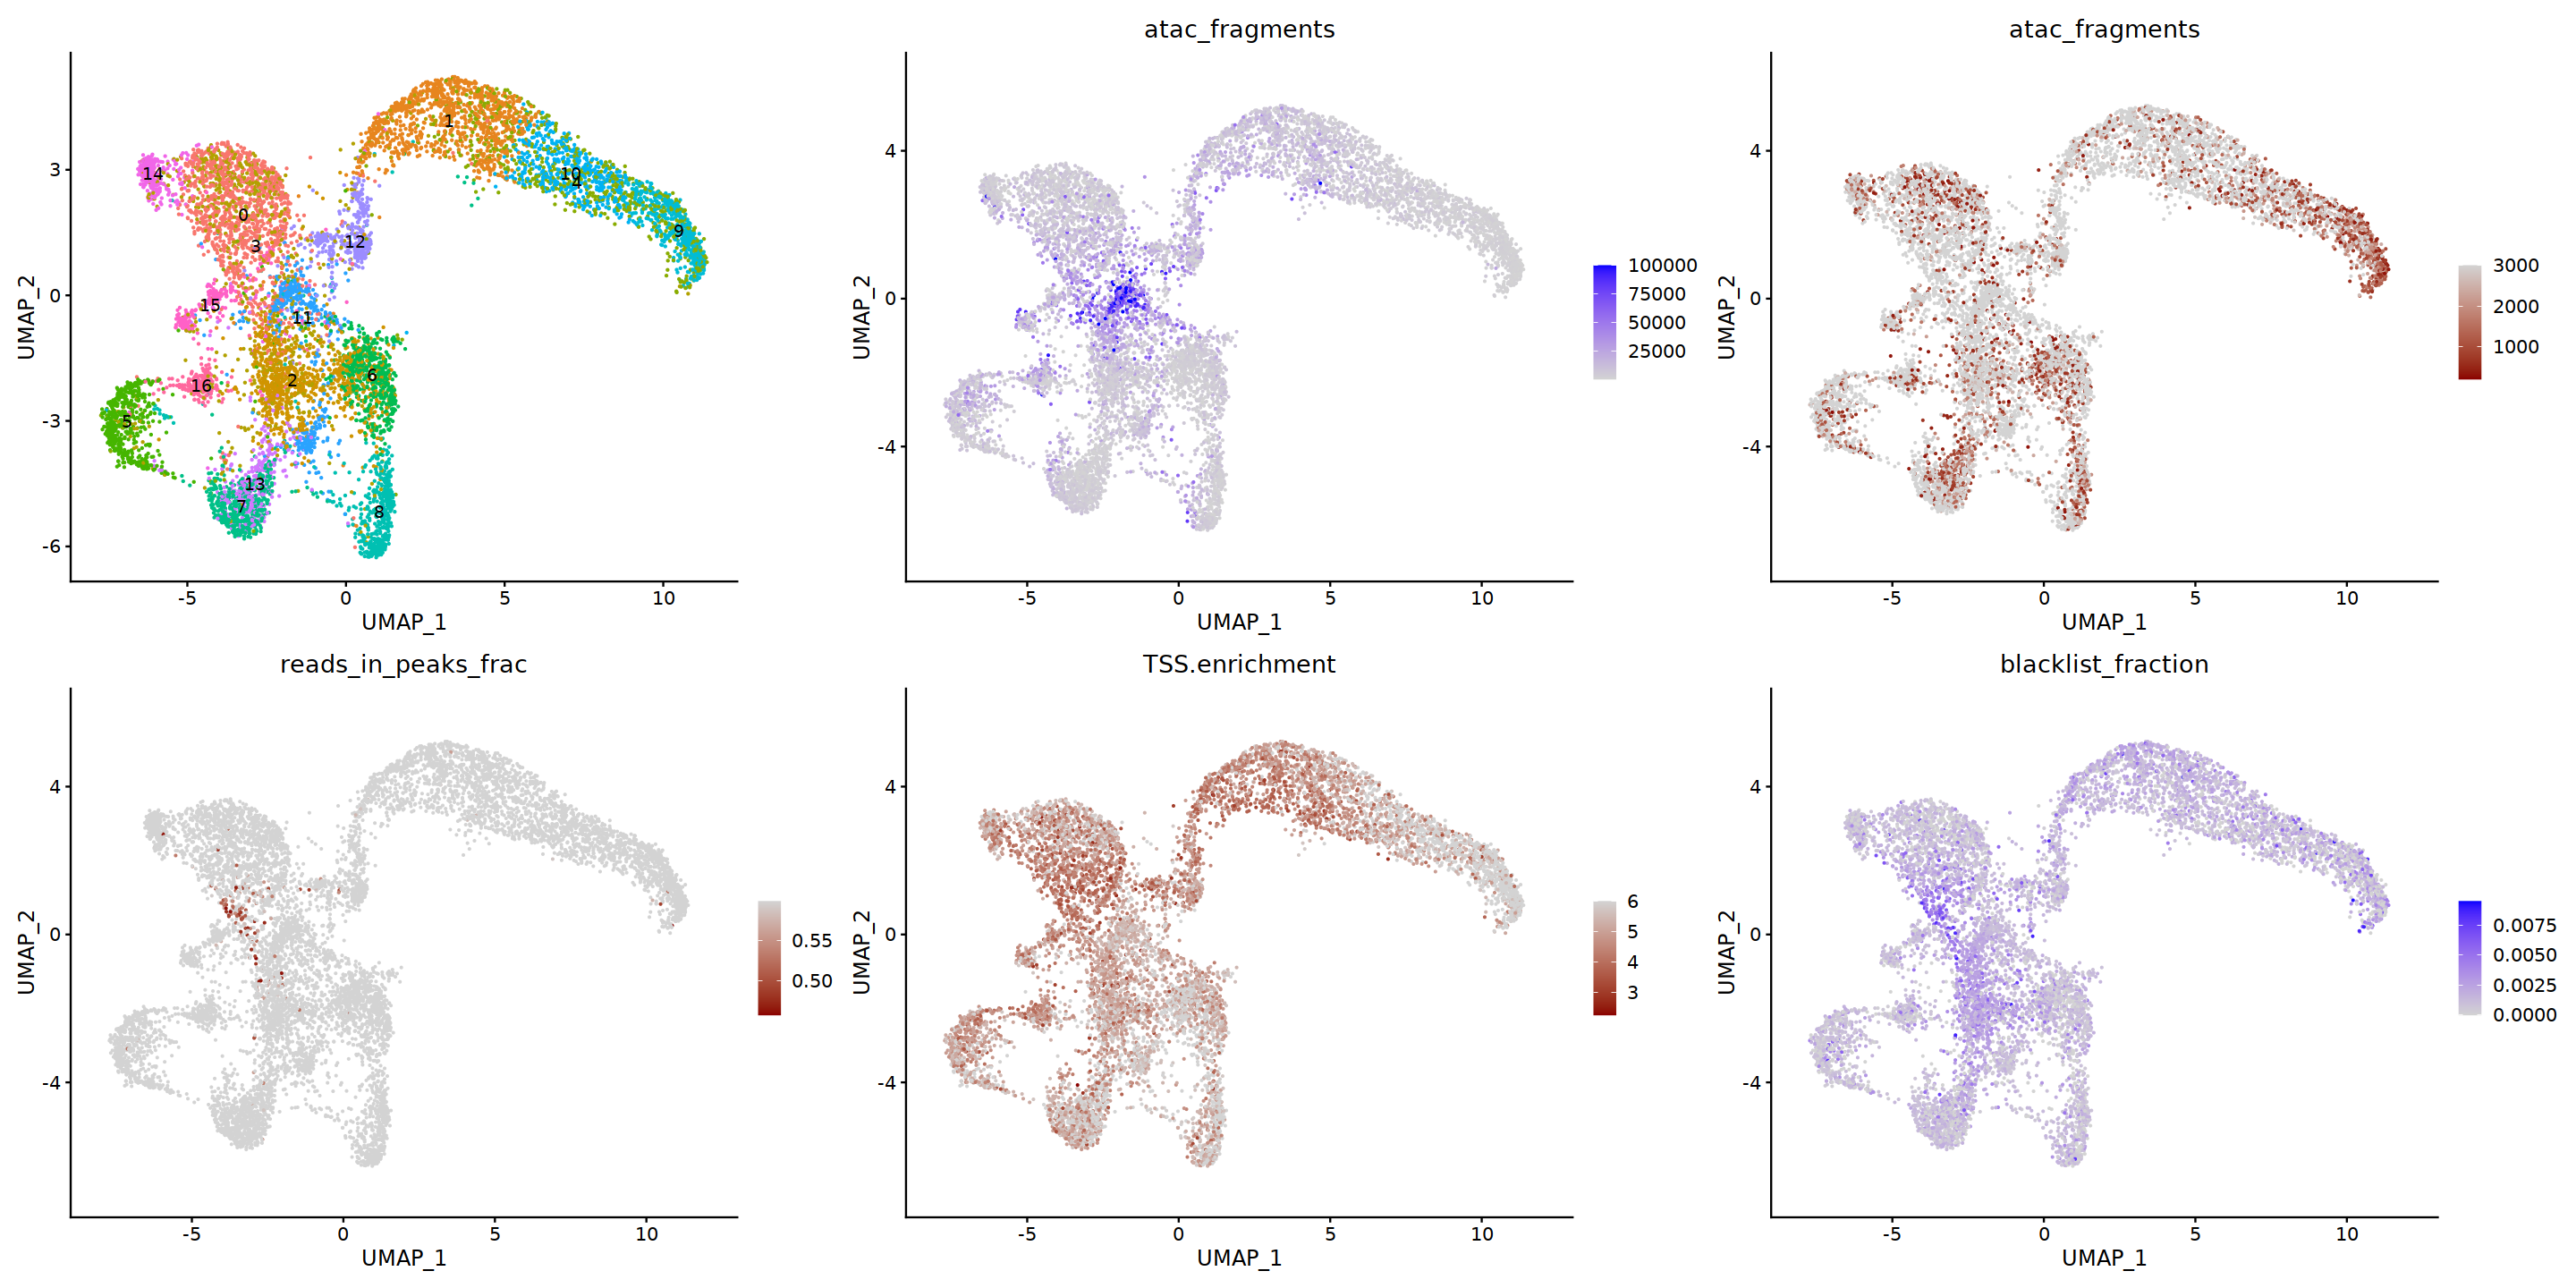

In [154]:
dimplot1 + peak_frac_pl + peak_frac_low_pl + per_in_peak_pl + tss_pl + bl_pl

**^^Plot above:**  Clear structure, highly similar to only removing one component;
high count cluster present (13) that has some cells sprinkeld across the UMAP

### Removing 1st, 2nd and 4th component

In [155]:
# Defining, which components to keep:
dims_to_use <- c(3,5:40)

In [156]:
bmnc_fltr_1a2a4 <- suppressMessages(RunUMAP(object = bmnc_filtered, reduction = 'lsi', dims = dims_to_use))

In [157]:
bmnc_fltr_1a2a4 <- FindNeighbors(object = bmnc_fltr_1a2a4, reduction = 'lsi', dims = dims_to_use)

Computing nearest neighbor graph

Computing SNN



In [158]:
bmnc_fltr_1a2a4 <- FindClusters(object = bmnc_fltr_1a2a4, verbose = FALSE, algorithm = 3)

In [159]:
options(repr.plot.width=24, repr.plot.height=12)

In [160]:
dimplot1 <- DimPlot(object = bmnc_fltr_1a2a4, label = TRUE) + NoLegend()

In [161]:
peak_frac_pl <- FeaturePlot(
  object = bmnc_fltr_1a2a4,
  features = 'atac_fragments',
  pt.size = 0.1,
  max.cutoff=100000
)

In [162]:
peak_frac_low_pl <- FeaturePlot(
  object = bmnc_fltr_1a2a4,
  features = 'atac_fragments',
  pt.size = 0.1,
  max.cutoff=3000,
  cols = c("darkred", "lightgrey")
)

In [163]:
tss_pl <- FeaturePlot(
  object = bmnc_fltr_1a2a4,
  features = 'TSS.enrichment',
  pt.size = 0.1,
  max.cutoff=6,
  cols = c("darkred", "lightgrey")
)

In [164]:
per_in_peak_pl <- FeaturePlot(
  object = bmnc_fltr_1a2a4,
  features = 'reads_in_peaks_frac',
  pt.size = 0.1,
  max.cutoff=0.6,
  cols = c("darkred", "lightgrey")
)

In [165]:
bl_pl <- FeaturePlot(
  object = bmnc_fltr_1a2a4,
  features = 'blacklist_fraction',
  pt.size = 0.1,
  max.cutoff=0.01
)

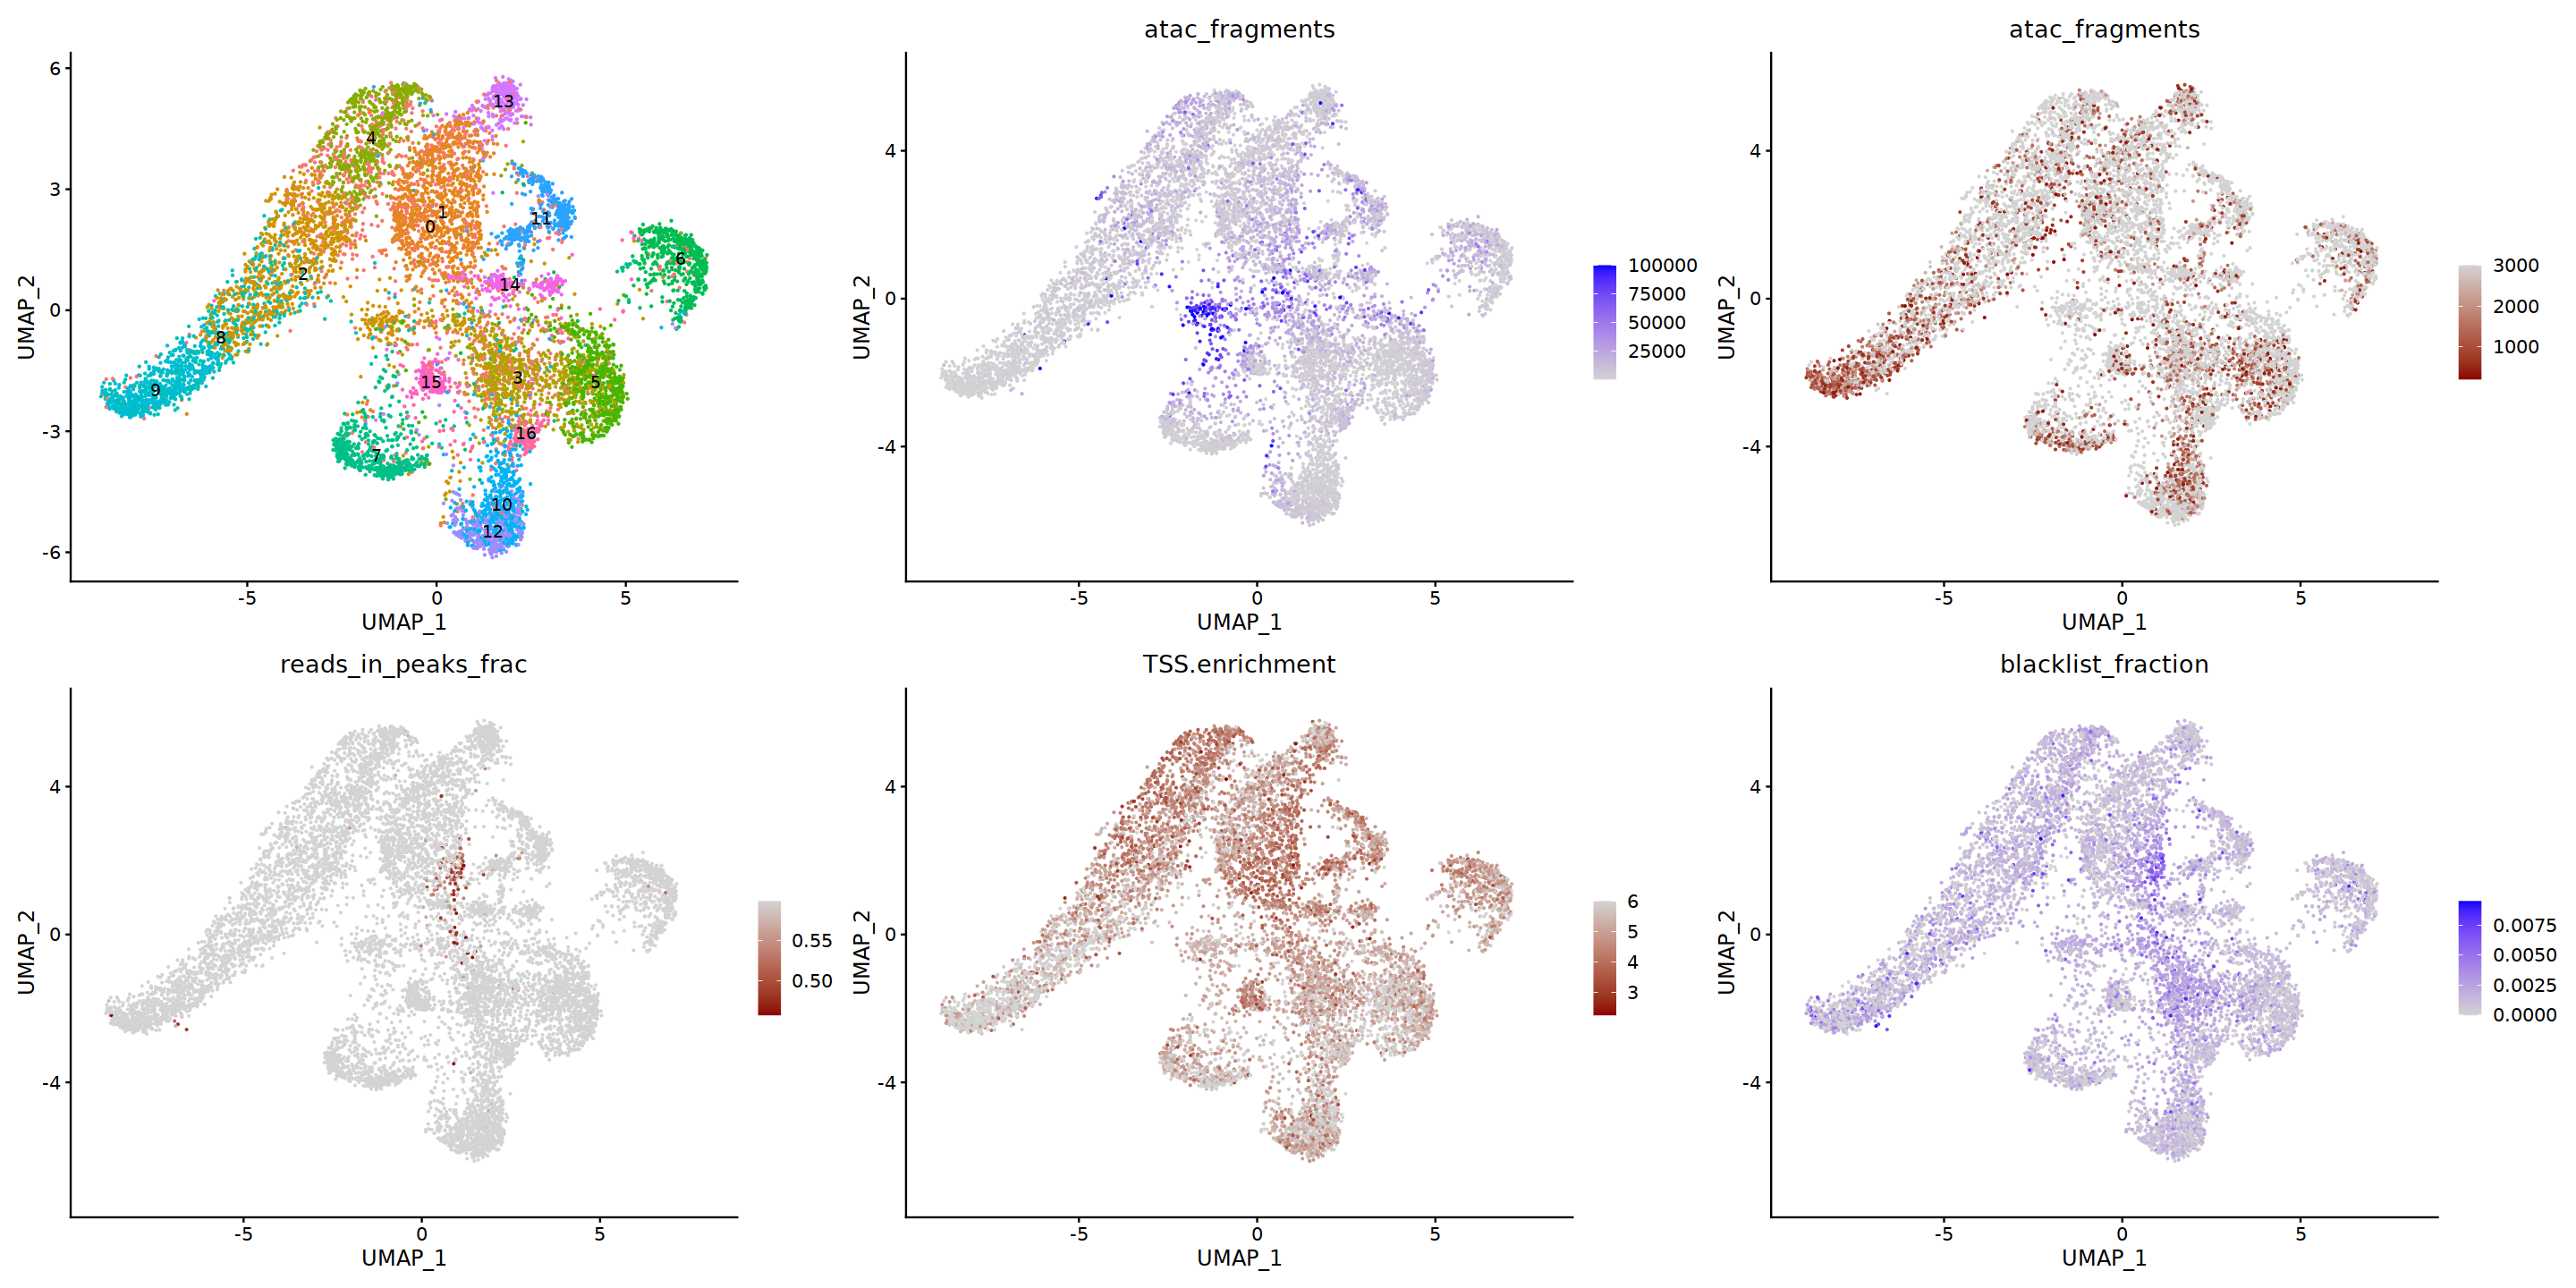

In [166]:
dimplot1 + peak_frac_pl + peak_frac_low_pl + per_in_peak_pl + tss_pl + bl_pl

**^^Plot above:**  Still a good representation, but some substructure of the small clusters seems to get 

## Get gene activities

Now that we have filtered the cells and decided on a dimensionality reduced embedding, we add interpretability to our data by generating a gene activity matrix based on the peak matrix. (takes several monutes)

In [167]:
# select object to add gene activity
bmnc_selected <- bmnc_fltr_1

# Define lsi components that should be used for downstream processing
lsi_comps = c(2:40)

In [168]:
gene.activities <- GeneActivity(bmnc_selected)

Extracting gene coordinates

Extracting reads overlapping genomic regions



In [169]:
# add the gene activity matrix to the Seurat object as an RNA assay and normalize it
bmnc_selected[['RNA']] <- CreateAssayObject(counts = gene.activities)

In [170]:
bmnc_selected <- NormalizeData(
  object = bmnc_selected,
  assay = 'RNA',
  normalization.method = 'LogNormalize',
  scale.factor = median(bmnc_selected$nCount_RNA)
)

### Save as R object

In [171]:
saveRDS(bmnc_selected, file = "data/bmnc_fltr_geneAct.rds")

In [172]:
# Loading
#bmnc_selected <- readRDS(file = "data/multiome/proc_data/s1d1/bmnc_fltr_geneAct.rds")

### Save as anndata

In [173]:
meta_keep <- c('nCount_peaks', 'atac_fragments', 'TSS.enrichment',
               'reads_in_peaks_frac', 'blacklist_fraction',
               'nucleosome_signal')

In [178]:
# Create adata - Gene activity in adata.X and peaks in adata.obsm
adata <- anndata::AnnData(X = t(bmnc_selected[['RNA']]@data))

In [179]:
# Add meta data
adata$obs = bmnc_selected@meta.data[,meta_keep]

# Save binarized counts
adata$obsm[['peaks']] <- t(bmnc_selected[['peaks']]@counts)

# Save LSI and UMAP embeddings
adata$obsm[['lsi_full']] <- Embeddings(bmnc_selected, reduction = "lsi")
adata$obsm[['lsi_red']] <- Embeddings(bmnc_selected, reduction = "lsi")[,lsi_comps]

adata$obsm[['umap']] <- Embeddings(bmnc_selected, reduction = "umap")

In [177]:
adata

AnnData object with n_obs × n_vars = 10062 × 158155
    obs: 'site', 'donor', 'donor_single'
    var: 'gene_ids', 'feature_types', 'genome'

In [181]:
# Save to disk 
adata$write_h5ad("data/adata_geneAct.h5ad",
                compression = "gzip")

None

In [1]:
adata$obs_names

ERROR: Error in eval(expr, envir, enclos): object 'adata' not found
